# Pittsburgh Bike Share Ridership Demand Prediction

__Introduction:__

Bike sharing systems have been increasing in demand over the past two decades as a result of rapid advancements in technology. Healthy Ride is a public bicycle sharing system that serves parts of Pittsburgh to fulfill the growing need for changes in mobility pattern. Healthy Ride is operated by Pittsburgh Bike Share and has plans for expansion to reach new neighborhoods by adding more stations, including several electric bikes to help riders navigate Pittsburgh’s hilly geography, located throughout the city. 
In this project, we determine the results of machine learning models such as decision tree, Lasso, Ridge Regression, Random forests, Support-Vector, XG Boosting, Gradient Boosting and Linear Regression. The effect of factors such as weather, geographic location, time of day, day of week. Bike score, Walk-score, distance between stations etc. on the number of bikes at bike-share station are investigated.

__Problem:__

Bike-sharing systems are used world-wide. Given that the system tends to be unbalanced, there are challenging analytical issues such as accurately predicting the demand. This project explores on predicting the total number of bikes rented from individual stations on any given day.

__Clients:__

Bike sharing operators can use this model to proactively shape the mobility market by forecasting demand prediction and to meet customer expectations.

__Project Workflow:__

A project flowchart below shows the order of methods involved in the completion of this project. 


<img src="flowchart.png" style="height:450px">

In [2]:
#import the necessary libraries

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import graphviz
import matplotlib
%matplotlib inline

In [3]:
#Load the csv file as pandas Dataframe
df = pd.read_csv("bike_share_rides1.csv", parse_dates = ["start_time","stop_time"])


In [80]:
# dimensionality of the DataFrame
print(f'The dataframe has {df.shape[0]} rows of data and {df.shape[1]} columns')

The dataframe has 267260 rows of data and 28 columns


In [81]:
#The column labels of the DataFrame:
df.columns

Index(['trip_id', 'start_time', 'stop_time', 'bike_id', 'trip_duration',
       'from_station_id', 'from_station_name', 'to_station_id', 'station_name',
       'user_type  ', 'from_latitude', 'from_longitude', 'to_latitude',
       'to_longitude', 'TMAX', 'TMIN', 'season', 'holiday', 'walk_score',
       'transit_score', 'bike_score', 'distance', 'event_type', 'rain', 'wind',
       'weather', 'tripdate', 'num_trips_day'],
      dtype='object')

In [82]:
#Return the first 2 rows
df.head(2)

,trip_id,start_time,stop_time,bike_id,trip_duration,from_station_id,from_station_name,to_station_id,station_name,user_type,...,walk_score,transit_score,bike_score,distance,event_type,rain,wind,weather,tripdate,num_trips_day
0,10676972,2015-05-31 06:54:00,2015-05-31 10:17:00,70166,12190,1018,Butler St & Stanton Ave,1001,Forbes Ave & Market Square,Customer,...,90.0,62.0,75.0,2.67,N,0.37,8.95,2.0,2015-05-31,480
1,10677086,2015-05-31 06:57:00,2015-05-31 09:24:00,70368,8842,1018,Butler St & Stanton Ave,1018,Butler St & Stanton Ave,Subscriber,...,90.0,62.0,75.0,0.00,N,0.37,8.95,2.0,2015-05-31,480


'The total number of trips made by each user category over the course of the time period from when the program went live on July 1st, 2015  to Dec 31st, 2018 are depicted in this chart'

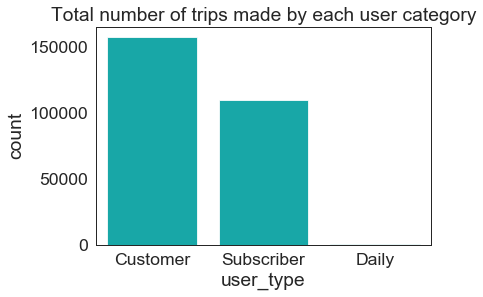

In [83]:
#Variable to hold datetime values:
#trips = df.copy()
i =  pd.to_datetime(df.start_time)
#Transforming columns to split by date, hour or month
df['date'] = i.dt.date
df['hour'] = i.dt.hour
df["month"] = i.dt.month
#The total number of trips made by each user category over the course of the time period are depicted in the chart below:
df.columns =df.columns.str.replace(' ', '')    
sns.countplot(x = "user_type", data = df
              , color = "c" ).set_title("Total number of trips made by each user category");
"""The total number of trips made by each user category over the course of the time period from when the program went live on July 1st, 2015  to Dec 31st, 2018 are depicted in this chart"""

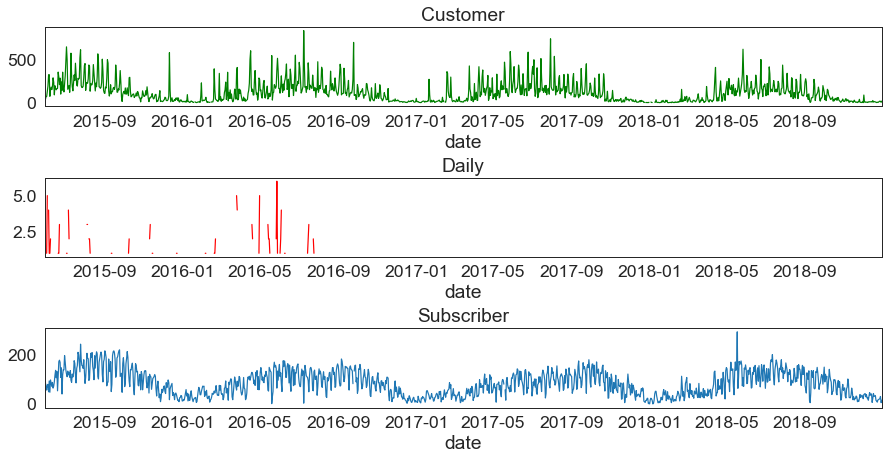

In [84]:
# Count trips by date

by_date = df.pivot_table('trip_id', aggfunc='count', index = "date",columns='user_type' )
fig, ax = plt.subplots(3, figsize=(15, 7))
fig.subplots_adjust(hspace=0.9)
by_date.iloc[:, 0].plot(ax=ax[0],color = "green", title ="Customer");
print("\n")
by_date.iloc[:, 1].plot(ax=ax[1], color = "red",title ="Daily");
by_date.iloc[:, 2].plot(ax=ax[2],title ="Subscriber");


Compared to other user types such as Customer passes and Subscriber passes, Daily pass user type counts looks negligible. There is no corresponding category for daily passes on Healthy ride website as well. It can be concluded from the graph above that the daily passes was issued inconsistently from 2015,Quarter 2 to 2016, Quarter 2. Since there were only 186 instances out of total 267260 rider counts , it will be excluded from further analysis.

In [85]:
#Drop rows containing Daily subscribers from df
df.drop(df.loc[df['user_type']=="Daily"].index, inplace=True)

Text(0.5, 1.0, 'Most popular start stations')

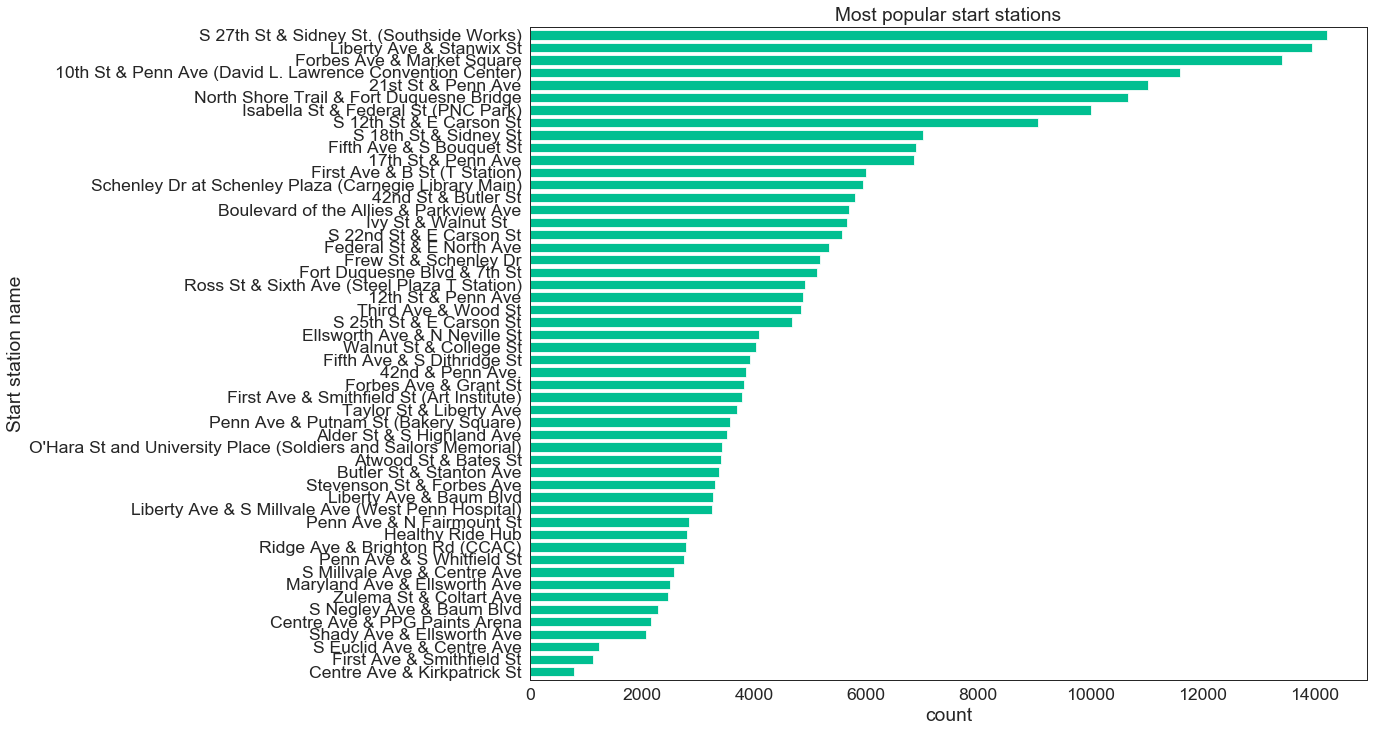

In [86]:
#visualize the popular start stations based on the number of trips taken
x = df['from_station_name'].value_counts().sort_values()
x.plot(kind='barh',figsize=(15, 12), color='#01bf91',  width=0.75);
plt.xlabel("count")
plt.ylabel("Start station name")
plt.title("Most popular start stations")

The plot above is used to visualize the top 15 most popular start stations based on the trip counts. “S 27th St & Sidney St. (Southside Works)” seems to be most popular followed by” Liberty Ave & Stanwix St”, and “Centre Ave & Kirkpatrick St” seems to be the least popular.

In [87]:
# convert trip duration into minutes
df["tr_du_mins"] =df['trip_duration'].div(60)

# converting trip duration into hours
df["tr_du_hr"] = df["tr_du_mins"].div(60)

# to calculate how fast does the rider rides the bike, i will be creating a new column "speed" which calculates the speed in miles per hour
df['speed'] = round(df['distance'] /df['tr_du_hr'], 2)

df['speed'].value_counts()


0.00      70716
0.05        555
0.06        545
0.04        535
0.07        535
0.12        515
0.10        513
0.03        507
0.09        495
0.15        494
0.08        492
0.02        478
0.11        475
0.13        467
0.14        463
0.17        419
0.16        412
5.14        406
0.21        403
0.20        389
0.19        384
0.18        378
0.25        370
5.41        352
0.32        352
0.22        340
0.23        340
0.30        339
0.28        339
4.73        339
          ...  
20.68         1
14.22         1
15.45         1
42.06         1
37.49         1
37.26         1
14.09         1
162.00        1
11.44         1
34.84         1
23.06         1
19.71         1
16.02         1
15.05         1
30.14         1
15.30         1
94.74         1
14.62         1
34.98         1
41.50         1
43.20         1
47.63         1
15.70         1
15.84         1
17.95         1
71.05         1
147.54        1
15.89         1
14.60         1
19.73         1
Name: speed, Length: 181

As we can see, 70716 zero values are recorded where start station and stop station are same and distance is 0.Professional bicycle racers can usually maintain 25-28 mph on flat ground. Let's plot a seaborn regplot to find outliers by plotting speed in miles/hour in y-axis and count in horizontal axis.

Text(0, 0.5, 'speed(mph)')

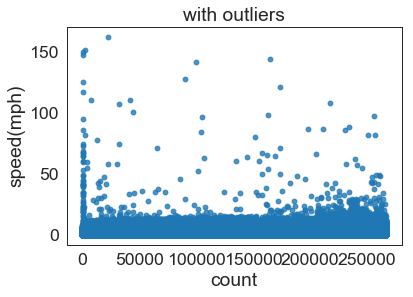

In [88]:
#Since Seaborn doesn't play nice with dates, I'll create a row count column that we can use as our y-axis\n",
df.insert(df.shape[1],'row_count',df.index.value_counts().sort_index().cumsum())
ax = sns.regplot(x=df["row_count"], y=df["speed"], fit_reg=False);
ax.set_title('with outliers')
ax.set_xlabel("count")
ax.set_ylabel('speed(mph)')

In [89]:
#drop rows containing speed value as 0
df.drop(df.index[df['speed'] == 0], inplace = True)# for data visualization purposes
df.drop(df.index[df['speed'] >= 30], inplace = True)
# Even professional bicycle racers can usually maintain 25-28 mph on flat ground
df.speed.describe()

count    196230.000000
mean          4.366559
std           2.665704
min           0.010000
25%           2.340000
50%           4.480000
75%           6.150000
max          29.880000
Name: speed, dtype: float64

Text(0, 0.5, 'speed(mph)')

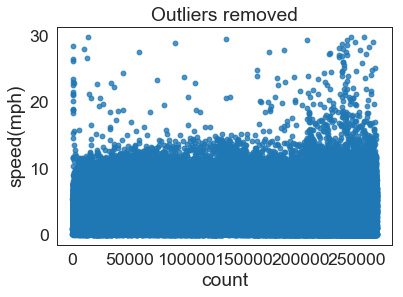

In [90]:
#visualizing after removing outliers
ax =sns.regplot(x=df["row_count"], y=df["speed"], fit_reg=False);
ax.set_title('Outliers removed')
ax.set_xlabel("count")
ax.set_ylabel('speed(mph)')

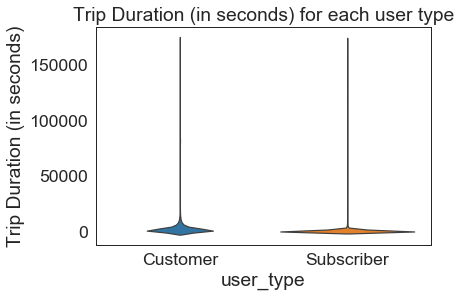

In [91]:
#Generate the violin plot of trip duration in seconds in y-axis and user types in horizontal axis
sns.violinplot(x='user_type', y='trip_duration', data=df, inner = None)
_= plt.title("Trip Duration (in seconds) for each user type")
_=plt.ylabel("Trip Duration (in seconds)")
# Display the plot

The violin plot of trip duration in seconds for each user type has a lot of anomalies. I will generate a box plot of user_type using the trip duration into minutes

In [92]:
#sns.boxplot(x='user_type', y="tr_du_mins", data=df);

Trip duration over 175 minutes do not represent the vast majority of users. According to Healthy Rides website, Customers can take unlimited 15-min trips all day, everyday and if they go over 15-min ride, they will be charged 2 dollars+ tax per 30-mins. Hence, trips over 175 minutes long will be excluded from further analysis.

In [93]:
df.drop(df.loc[df['tr_du_mins']>= 175].index, inplace=True)

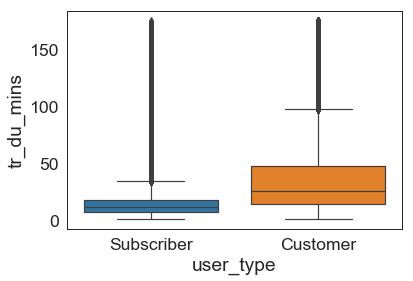

In [94]:
sns.boxplot(x='user_type', y="tr_du_mins", data=df);

In [95]:
#Copying df as df1
df1 = df.copy()
df1['start_time'] =  pd.to_datetime(df1['start_time'])
df1['weekday'] = df1['start_time'].dt.dayofweek
df1['weekday'].value_counts()

5    31111
4    28008
6    27493
2    27122
1    25860
3    25180
0    24636
Name: weekday, dtype: int64

In [96]:
#trips on work week days (M-F) (including holidays)
df1.groupby('weekday').size().reset_index().rename(columns={'dayweek': 'weekday', 0:'trips'})
len(df1[df1['weekday'] <5])
#trips on weekends (Sa + Su)
#len(df1[df1['weekday'] >=5])
#work week days (M-F) (including holidays)
wh = df1[df1['weekday'] <5]
print('work week days:',len(wh))
holidays = wh[wh.holiday ==1]
print('number of holidays:',len(holidays))
#number of times each day of the week occured 
#0 indicates Monday
weekday_counts = pd.DataFrame({'weekday': [0, 1, 2, 3, 4, 5, 6],
         'days': [52, 52, 52, 52, 52, 52, 53]})
#print('weekday_counts:',weekday_counts)
      
#dataframe of trips by day of week
weekday_trips = df1.groupby('weekday').size().reset_index().rename(columns={'weekday': 'weekday', 0:'trips'})
#weekday_trips
#dataframe of total trips by day of week, number of times each weekday occured 
#and the average number of trips for each day of week
weekday = pd.merge(weekday_trips, weekday_counts, on = 'weekday', how = 'outer')
weekday['average'] = weekday['trips'] / weekday['days']
print("\n")

work week days: 130806
number of holidays: 4290




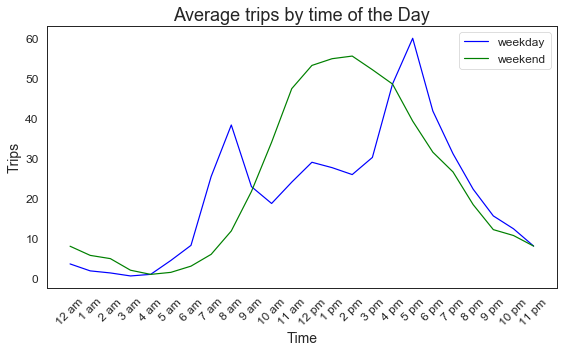

In [97]:
#creating a new dataframe with a DateTime index that will allow for plotting all trips over time more easily
bf = pd.DataFrame(df1.start_time.value_counts())

bf.index = pd.to_datetime(bf.index)
bf.sort_index(inplace = True)
bf.rename(columns={'starttime':'count'}, inplace = True)
#bf.head()
#this shows number of trips that occured by the second
#designating days of the week as weekends or weekdays to compare the two
weekend = np.where(bf.index.weekday < 5, 'Weekday', 'Weekend')

#Data resampled on an hourly basis 
hourly = bf.resample('H').sum()
hourly.head()
#data for just weekdays (M-F)
hourly_week = bf[weekend == 'Weekday'].resample('H').sum()

#averages for weekday times (including holidays)
hourly_week.groupby(hourly_week.index.hour).sum() / (weekday[:5].sum().days) 
#total sum of trips at each our for weekdays divided by the number of weekdays (M-F) 
#data for just weekends (Sa+Su)
hourly_weekend = bf[weekend == 'Weekend'].resample('H').sum()

hourly_weekend.groupby(hourly_weekend.index.hour).sum() / (weekday[5:].sum().days)
#total sum of trips at each our for weekends divided by the number of weekends (Sa+Su) 
print('\n')
#plot of average trips by hour of day for non-holiday weekdays and weekends together
plt.figure(figsize=(8,5))
#setting data
a = (hourly_week.groupby(hourly_week.index.hour).sum() / ((weekday[:5].sum().days) ))
g = hourly_weekend.groupby(hourly_weekend.index.hour).sum() / weekday[5:].sum().days


#plotting lines
plt.plot(a, 'b')
plt.plot(g, 'g')

plt.legend(['weekday', 'weekend'], fontsize=12)

#axes
plt.xticks(range(0,25), ['12 am', '1 am','2 am', '3 am', '4 am', '5 am', '6 am', '7 am', '8 am', '9 am', '10 am', '11 am','12 pm', '1 pm','2 pm', '3 pm', '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm'], fontsize=10)
plt.xticks(rotation=45)
ax.set_xlim(0, 24)
ax.set_ylim(0, 100)

plt.tick_params(axis='both', which='major', labelsize=12)

#labels
plt.title('Average trips by time of the Day', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Trips', fontsize=14)

plt.tight_layout()


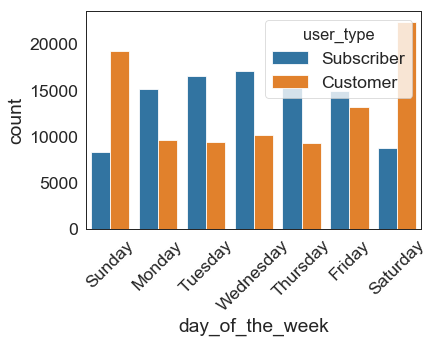

In [98]:
# Rotate the labels so you can read them
df1["start_time"]=pd.to_datetime(df1.start_time)
df1["day_of_the_week"] = df1["start_time"].dt.day_name()
h = df1["day_of_the_week"].value_counts()

# Setting a color pallette 
my_colors = ["indianred","salmon","lightcoral","salmon","darksalmon","peachpuff","mistyrose"]*5 # <-- this concatenates the list to itself 5 times.\n",

#Display the graph
#h.plot(kind = "bar", color= my_colors)
plt.xticks(rotation = 45)
sns.countplot(x="day_of_the_week",hue='user_type', data=df1);



It is evident from the plot above that more customers rent bikes than subscribers on Saturdays and Sundays. It is safe to assume that since Subscribers use bikes more on weekdays than on weekends according to the graph, they might be renting bikes to commute to office.

In [99]:
#Make new dataframe df_rides_day_hour2 to pivot our data and by day and hour, get the count of rides
df['start_time_hour'] = df['start_time'].dt.hour
df['start_time_day_name'] = df['start_time'].dt.weekday_name

df_rides_day_hour2 = pd.pivot_table(df[['start_time_day_name', 'start_time_hour', 'trip_duration']], index=['start_time_day_name', 'start_time_hour'], aggfunc='count')

#Unstack below puts days on the x-axis and hour of day on the y-axis.
df_rides_day_hour3 = df_rides_day_hour2.unstack(level=0)
df_rides_day_hour3.head(2)

trip_duration                                          \
start_time_day_name        Friday Monday Saturday Sunday Thursday Tuesday   
start_time_hour                                                             
0                             245    181      404    440      191     162   
1                             113     91      291    313      125      84   

                               
start_time_day_name Wednesday  
start_time_hour                
0                         162  
1                          77

[Text(40.5, 0.5, 'Starting time (by hour)'),
 Text(0.5, 40.5, 'Day of the Week')]

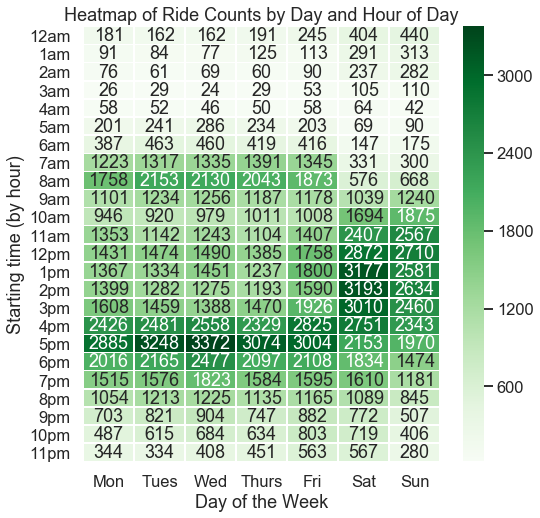

In [100]:
#Re-index axis so day of week appears in logical progression.
df_rides_day_hour3 = df_rides_day_hour3.reindex(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, level=1)

#Create new axis tick labels for easy to read hours and days of the week.
morning_hours = []
for hour in range(1, 12):
    detailed_hour = str(hour) + "am"
    morning_hours.append(detailed_hour)
afternoon_hours = []
for hour in range(1, 12):
    detailed_hour = str(hour) + "pm"
    afternoon_hours.append(detailed_hour)
detailed_hours = ["12am"] + morning_hours + ["12pm"] + afternoon_hours
day_short_names = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
#Plot Heatmap of Ride Counts by Day and Hour of Day
sns.set_context("talk")
f, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(df_rides_day_hour3, annot=True, fmt="d", cmap="Greens",linewidths=.5, ax=ax, xticklabels=day_short_names, yticklabels=detailed_hours)
ax.axes.set_title("Heatmap of Ride Counts by Day and Hour of Day", fontsize=18, y=2.01)
ax.set(xlabel='Day of the Week', ylabel='Starting time (by hour)')

The heat map above shows the total ride counts by hour of the day and Day of the week. On weekdays, Monday to Friday, most rides are taken from 7am to 7pm.On weekends, most rides are taken from 9am - 7pm.



Text(0.5, 1, 'Bike Rentals at Maximum Temperatures by seasons')

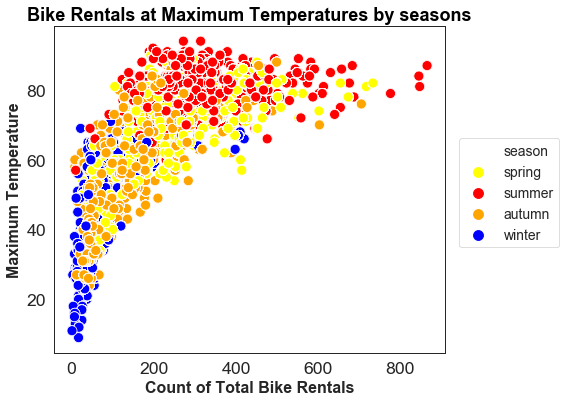

In [101]:
#The plot below depicts the seasonality of bike rentals based on temperatures:
   
plt.figure(figsize=(7,6))
fontdict={'fontsize': 18, 'weight' : 'bold', 'horizontalalignment': 'center'}
sns.set_context('paper', font_scale=2) #this makes the font and scatterpoints much smaller
sns.set_style('white')
sns.scatterplot(y='TMAX', x='num_trips_day', hue = 'season', data= df,  palette=['yellow','red','orange','blue'], legend='full', size='season', sizes=[100,100,100,100])
plt.legend(scatterpoints=1, bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=1., ncol=1, fontsize=14)
plt.ylabel('Maximum Temperature', fontsize=16, fontweight='bold')
plt.xlabel('Count of Total Bike Rentals', fontsize=16, fontweight='bold')
plt.title('Bike Rentals at Maximum Temperatures by seasons', fontdict=fontdict, color="black", position=(0.5,1))

The scatter plot above shows that as the temperature increases the count i.e. the number of total rentals also increases. The maximum number of rental counts seems to be when the temperature is between 60°F to 90°F. There is a clear seasonal trend where the total rental bikes seems to decrease during Winter and increase during summers.

In [102]:
'''0  = Worst weather including all the event types listed in the Storm dataset and WT02
1  = Moderate  weather including the values ( which are not already included in 1) listed in :
                    WT04 - Ice pellets, sleet, snow pellets, or small hail",
                    WT08 - Smoke or haze WT01 - Fog, ice fog, or freezing fog
                    WT03 - Thunder
2 = Good weather not listed in either 1 or 2'''
df['weather'].value_counts()
# renaming values of the column\n",
df['weather'] = df['weather'].map({0: "worst", 1: "moderate:worst", 2:"good"})
df["weather"].value_counts()

good              186077
moderate:worst      1944
worst               1389
Name: weather, dtype: int64

__Outlier detection:__

Let's remove outliers that deviates drastically from other observations in a dataset which might not necessarily problematic but can skew our model by affecting the slope.

In [103]:
#function to identify outliers
def find_outliers(x):
    #Values below Q1-1.5(Q3-Q1) or above Q3+1.5(Q3-Q1)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values
indices, values = find_outliers(df['wind'])
print(np.sort(values))

[15.21 15.21 15.21 ... 19.69 19.69 19.69]


In [104]:
# Use pyplot in matplotlib to plot histograms
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histogram(x):
    n = len(x)
    bins = int(np.sqrt(n))
    plt.hist(x, color='crimson',bins = bins, alpha=0.5)
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

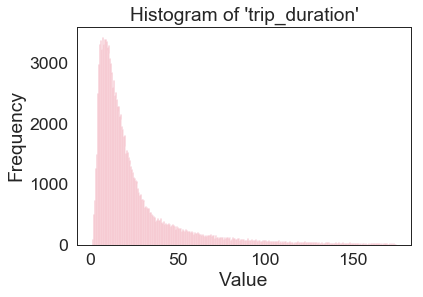

Outliers: [ 3513  3513  3513 ... 10496 10497 10498]


In [105]:
#plot histogram of trip duration with outliers
plot_histogram(df['trip_duration'].div(60))
indices, values = find_outliers(df['trip_duration'])
print(f'Outliers: {np.sort(values)}')

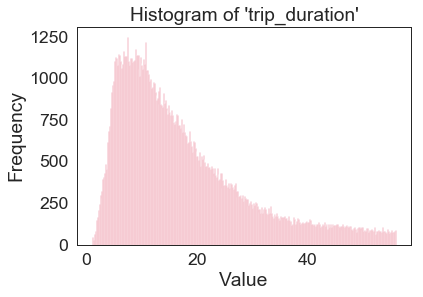

In [106]:
#plot histogram of trip duration with outliers removed
indexNames = df[df['trip_duration']>= 3366].index
df.drop(indexNames , inplace=True)
plot_histogram(df['trip_duration'].div(60))

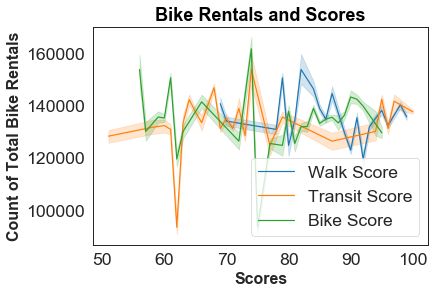

In [107]:
"Let's find outliers in walkscore, bike-score and transit-score columns"
ax = sns.lineplot(x="walk_score", y="row_count", data=df, label = "Walk Score");
ax = sns.lineplot(x="transit_score", y="row_count", data=df, label = "Transit Score");
ax = sns.lineplot(x="bike_score", y="row_count", data=df, label ="Bike Score");
ax.legend()
plt.xlabel('Scores', fontsize=16, fontweight='bold');
plt.ylabel('Count of Total Bike Rentals', fontsize=16, fontweight='bold');
plt.title('Bike Rentals and Scores', fontdict=fontdict, color="black", position=(0.5,1));

As per website , the location with bike score between 70 - 89 is considered as very bikeable. But the graph above shows anomalies at 75 and the bike rental counts drops drastically. Hence I will be deleting rows containing bike score of 75, and transit score equal to 61.



In [108]:
df.drop(df.index[df["bike_score"]==75 ],inplace = True)
df.drop(df.index[df["bike_score"]==61 ],inplace = True)

In [4]:
import os
from folium.plugins import MarkerCluster
import folium

from folium.plugins import HeatMap

remove_bad_values = False
city_name = 'Pittsburgh'
print("Pittsburgh Coordinates:")
min_lat = df["from_latitude"].min()
print(f"min_lat: {min_lat}")
max_lat = df["from_latitude"].max()
print(f"max_lat: {max_lat}")
min_lon = df["from_longitude"].min()
print(f"min_lon: {min_lon}")
max_lon = df["from_longitude"].max()
print(f"max_lon: {max_lon}")

Pittsburgh Coordinates:
min_lat: 40.428020000000004
max_lat: 40.470188
min_lon: -80.013204
max_lon: -79.91524799999998


In [5]:
# define centre of map
Pit_COORDINATES = (df['from_latitude'].mean(), df['from_longitude'].mean())
 
  
# create empty map zoomed in on Toronto
map_pit = folium.Map(location=Pit_COORDINATES, zoom_start=12)
df['count'] = 1

# define heat map

HeatMap(data=df[['from_latitude', 'from_longitude', 'count']].groupby(['from_latitude', 'from_longitude']).sum().reset_index().values.tolist(),
        radius=13, max_zoom=15).add_to(map_pit)


display(map_pit)

If we zoom into the map, concentrations of checkouts are evident in the three distinct hotspots near the lake where Gateway Station, First Avenue and Steel Plaza are located.

__Project: Inferential Statistics__

As per [article] (https://www.post-gazette.com/news/transportation/2018/12/02/Healthy-Ride-Pittsburgh-bike-sharing-program-adding-stations-new-neighborhoods/stories/201812020119)  published in  on DEC 3, 2018; there was a noticeable drop in ridership from 2016 to 2017. I would like to to test whether this hypothesis is commensurate with the data.  My consolidated dataset has data from  from 2015, Quarter 2 to 2018, Quarter 4.
The samples are independent of each other and are random. I would be perfoming a two sample, one-tailed upper test  Z test. I would be also be performing a two sample Bootstrap hypothesis test with null hypothesis being that there is no difference in means with regards to the average number of trip counts.

Null Hypothesis:

$ Ho : \mu_{1} = \mu_{2} $ 


Alternate Hypothesis:

$ Ha: \mu_{1} > \mu_{2}  $

Let's also explore the average number of trips taken in each station.

In [111]:
#Segregate the data based on the year
import datetime 
df["year"] = df['start_time'].dt.year

trips_2016, trips_2017 = df[df['year']==2016]['num_trips_day'], df[df['year']==2017]['num_trips_day']

In [112]:
def diff_of_means(data_1,data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) -  np.mean(data_2)

    return diff
empirical_diff_means = diff_of_means(trips_2016, trips_2017)
print(f"Trip_2016 mean : {np.mean(trips_2016)}")

print(f"Trip_2017 mean : {np.mean(trips_2017)}")
print(f"Empirical difference of means: {empirical_diff_means}")


Trip_2016 mean : 288.9645408217659
Trip_2017 mean : 267.6647634190999
Empirical difference of means: 21.299777402665995


The average number of trips of the year 2016 was 290.5237 , and that of year 2017 was 270.64891with a difference of 19.8748. It is possible this observed difference in mean of trip counts was by chance. We will compute the probability of getting at least a 19.8748 difference in average number of trips under the hypothesis that the average number of trip counts in both years are identical.

ECDFs are often even better when doing Exploratory Data Analysis. ECDF is Empirical Cumulative Distribution Function . x- value of ECDF is the quantity you are measuring. The y value(0 to 1 probalibility) is the fraction of datapoints that have a value smaller than the corresponding x value.

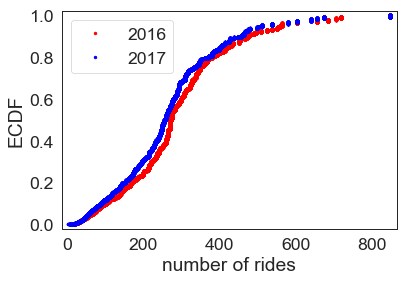

In [113]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1)/float(len(data))


# Create and plot ECDFs from original data
x_1, y_1 = ecdf(trips_2016)
x_2, y_2 = ecdf(trips_2017)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', label ="2016")
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue',label = "2017")

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('number of rides')
_ = plt.ylabel('ECDF')
_ = plt.legend()
plt.show()


Frequentist Approach:

For our hypothesis to be true, we are going to figure out the probability of getting the actual difference of  means between 2016 and 2017 to be zero under the assumption that our hypothesis is correct. It is going to be a one-tailed upper test. I will set aplha to be 0.05. 
Alpha level is the probability of making te wrong decision when the null hypothesis is true.

Null Hypothesis:

$ Ho : \mu_{1} = \mu_{2} $ 


Alternate Hypothesis:

$ Ha: \mu_{1} > \mu_{2}  $


The Z-test is used to compare the population mean against a sample or compare the population mean of two distributions with a sample size greater than 30. The samples are independent of each other and are random. First, we calculate the z-score to find how many standard deviations away  from $\mu$ as below:

Mean of number of rides per day in 2016($\mu_1$)  = 177.53$

Mean of number of rides per day in 2017($\mu_2$)  = 164.87$

Difference of means between 2016 and 2017 = diff_of_means(trips_2016, trips_2017)

Standard Error(SE) is the standard error of the distribution of differences which is also the standard deviation of that sampling distribution:

SE =  $\sqrt{\frac{\sigma^2_1 }{n_1} + \frac{ \sigma^2_2 }{n_2}}$ 


We can calculate the pooled sample of mean and the standard error (SE) from the sample data. Using those measures, we can compute the z-score test statistic (z).

μo is Hypothesized mean difference which is 0 in this case because according to null hypothesis is there’s no difference.
μo = 0

z-score  = $\frac{(\mu_1 - \mu_2 )- \mu_0}{\sqrt{\frac{\sigma^2_1 }{n_1} + \frac{ \sigma^2_2 }{n_2}}}$

If the Z-score falls in the rejection region, and when the p-value is less than the threshold significance level, which in our case is 5%, we can conclude that the results in difference of means was in fact statistically significant and reject the null hypothesis. Else we fail to reject the null hypothesis.


In [114]:
import scipy
from scipy import stats

#Segregate date based on year
trips_2016, trips_2017 = df[df['year']==2016]['num_trips_day'], df[df['year']==2017]['num_trips_day']


# number of  trips taken  per day in 2016
n_2016 =sum(df[df.year==2016].num_trips_day)
print(f"Total number of trips taken per day in 2016 (n_2016) :{n_2016}")

# number of  trips taken per day in 2017
n_2017 =sum(df[df.year==2017].num_trips_day)
print(f"Total number of rides taken per day in 2017 (n_2017) :{n_2017}")

# number of trips
n1 = len(trips_2016)
print(f"Number of days in trip_2016 data (n1): {n1}")

# number of trips
n2 = len(trips_2017)
print(f"Number of days in  trips_2017 data(n2): {n2}")

"""Alpha level is the probability of making the wrong decision when the null hypothesis is true."""
# Find 95% confidence intervals
crit = stats.norm.isf(0.05)
print(f" Critical value(z-crit) or the boundary of 95% confidence interval of one-tailed upper right test when alpha(rejection region) = 0.05 is +{crit}")
     

#μo which is Hypothesized mean difference is 0 because according to null hypothesis is there’s no difference.
μo = 0

"""SE is the standard error of the distribution of differences which is also the standard deviation of tht sampling distribution"""
SE = np.sqrt((np.std(trips_2016) ** 2/ n1) + (np.std(trips_2017) ** 2/ n2))
print(f"One standard deviation away from 0 would be {SE} SE ")

print(f"Margin of error for interval estimates of difference for these samples is {crit * SE}")

z = ((diff_of_means(trips_2016, trips_2017)) - μo) / SE

print(f"we expect 95% of the sample differences to be in this region: {crit * SE}")
print(f"Z-score  is {z}")

p_val = scipy.stats.norm.sf(abs(z))

if p_val < 0.05:
    print("Since p-value < 0.05, we reject Null Hypothesis")
else:
    print("Accept null hypothesis")

Total number of trips taken per day in 2016 (n_2016) :13552148
Total number of rides taken per day in 2017 (n_2017) :11110229
Number of days in trip_2016 data (n1): 46899
Number of days in  trips_2017 data(n2): 41508
 Critical value(z-crit) or the boundary of 95% confidence interval of one-tailed upper right test when alpha(rejection region) = 0.05 is +1.6448536269514729
One standard deviation away from 0 would be 0.9713969637389736 SE 
Margin of error for interval estimates of difference for these samples is 1.597805819015699
we expect 95% of the sample differences to be in this region: 1.597805819015699
Z-score  is 21.92695488843376
Since p-value < 0.05, we reject Null Hypothesis


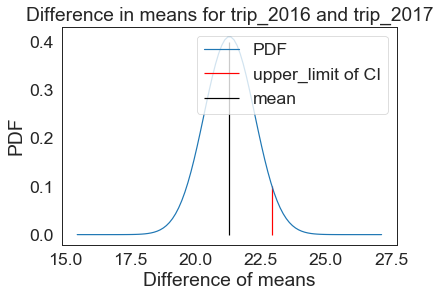

In [115]:
import pylab

# find Margin of error(m)
SE = np.sqrt((np.std(trips_2016) ** 2/ n1) + (np.std(trips_2017) ** 2/ n2))
mu = diff_of_means(trips_2016, trips_2017) 
z = ((diff_of_means(trips_2016, trips_2017)) - 0) / SE
#In an upper tailed Z test, if α =0.05 then the critical value is Z=1.645.
m = 1.645
max_p = mu + m
v = SE * SE
s = SE
x = np.linspace(mu - 6*SE, mu + 6*SE, 100)
y1 = stats.norm.pdf(x, loc=mu, scale=s)    
pylab.plot(x,y1)
pylab.xlabel('Difference of means')
pylab.ylabel('PDF')
pylab.vlines(max_p,0,0.1, color='red')
pylab.vlines(mu,0, .4)
pylab.legend(['PDF', 'upper_limit of CI',"mean" ], loc = "upper right")
pylab.title('Difference in means for trip_2016 and trip_2017')
pylab.show()


The Z-score falls in the rejection region, and the p-value is less than the threshold significance level, which in our case is 5%, we can conclude that the results in difference of means was in fact statistically significant and we can reject the null hypothesis.

__Model Evaluation:__

Other outliers from features such as Speed, distance etc., were removed using find_outliers function and saved the dataframe as "file1.csv" and reloaded as df below:

In [66]:
#reload the csv file as df after removing outliers
df= pd.read_csv("file1.csv",index_col='tripdate',parse_dates=['start_time','stop_time'],error_bad_lines=True, warn_bad_lines=True)

In [67]:
# Create subset of only the numeric columns
numeric_df =df.select_dtypes(include=['int64','int','float']).astype('float')

# Print the column names contained in so_survey_df_num
print(numeric_df.columns)


Index(['trip_duration', 'from_station_id', 'to_station_id', 'holiday',
       'distance', 'rain', 'wind', 'year', 'weekend', 'speed', 'weekday',
       'num_trips_day', 'hour', 'month', 'temp_mean', 'event_types'],
      dtype='object')


In [68]:
# categorical variables
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weather'] = df.weather.astype('category')
df['month'] = df.month.astype('category')
df['year'] = df.year.astype('category')
df['hour'] = df.hour.astype('category')
df['weekend'] = df['weekend'].astype('category')
df['from_station_id'] = df['from_station_id'].astype('category')
df['to_station_id'] = df['to_station_id'].astype('category')
df['event_types'] = df['event_types'].astype('category')

In [69]:
df.dtypes

start_time         datetime64[ns]
stop_time          datetime64[ns]
trip_duration             float64
from_station_id          category
to_station_id            category
user_type                  object
season                   category
holiday                  category
walk_score                 object
transit_score              object
bike_score                 object
distance                  float64
rain                      float64
wind                      float64
weather                  category
year                     category
weekend                  category
speed                     float64
weekday                  category
num_trips_day             float64
hour                     category
month                    category
temp_mean                 float64
event_types              category
dtype: object

In [70]:
df.drop(['start_time','stop_time'], axis = 1,inplace = True)

__Encoding:__
    
To use categorical variables in a machine learning model, we first need to represent them in a quantitative way. We will make our own transformer, which applies the LabelEncoder in each of the relevant features. Then, let’s try to apply the OneHotEncoder directly to both the training and test sets using category encoders.

In [71]:
import category_encoders as ce
from category_encoders import *
le = LabelEncoder()
numeric_cols = ['trip_duration','distance', 'rain', 'wind', 'speed','hour','temp_mean']
label_cat_features = ['from_station_id','to_station_id', 'month','event_types']
ohe_cat_features =  ['season','year','weather','user_type', 'walk_score','transit_score','weekend','weekday', 'bike_score','holiday']
#ord_features = ['start_time', 'stop_time']

X , y = df.drop('num_trips_day', 1).values, df.num_trips_day.values
#df.drop(['start_time','stop_time'], axis = 1, inplace = True)
X_train_df, X_test_df, y_train, y_test = train_test_split(df.drop('num_trips_day', 1), df.num_trips_day, 
                                                    test_size=0.33, random_state=42)


def encoding(X_train_df, X_test_df, numeric_cols,label_cat_features,ohe_cat_features):
   
    for x in label_cat_features:
        names = le.fit_transform(X_train_df[x])
        names_mappings = {index: label for index, label in enumerate(le.classes_)}
        X_train_df[x] = names
        names2 = le.transform(X_test_df[x])
        names_mappings = {index: label for index, label in enumerate(le.classes_)}
        X_test_df[x] = names2
        
    # use one hot encoding to encode categorical features
    ohe = OneHotEncoder(cols=ohe_cat_features, use_cat_names=True).fit(X_train_df)
    # transform the datasets
    X_train_df = ohe.transform(X_train_df)
    X_test_df = ohe.transform(X_test_df)
    
    return X_train_df, X_test_df, 
df1 = encoding(X_train_df, X_test_df, numeric_cols,label_cat_features,ohe_cat_features)

In [72]:
X_train, X_test = df1[0].astype(float),df1[1].astype(float)

In [10]:
X_train.head(2)

,trip_duration,from_station_id,to_station_id,user_type_Subscriber,user_type_Customer,season_autumn,season_spring,season_summer,season_winter,holiday_0.0,...,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour,month,temp_mean,event_types
tripdate,,,,,,,,,,,,,,,,,,,,,
2017-04-23,6.077642,23.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,17.0,3.0,3.960813,0.0
2018-07-30,5.638355,10.0,11.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,4.248495,0.0


In [11]:
#function to compare results
from sklearn.metrics import mean_squared_error, r2_score
def validate_result(model, model_name):
    
    ## Predict on the test data: y_pred scaled
    predicted = model.predict(X_test)
    # Compute and print R^2 and RMSE
    RSME_score = np.sqrt(mean_squared_error(y_test, predicted))
       
    R2_score = r2_score(y_test, predicted)
    print(model_name,':')
    
    print('R2 score: ', R2_score)
    print('RMSE: ', RSME_score)
    

In [12]:
df.columns

Index(['trip_duration', 'from_station_id', 'to_station_id', 'user_type',
       'season', 'holiday', 'walk_score', 'transit_score', 'bike_score',
       'distance', 'rain', 'wind', 'weather', 'year', 'weekend', 'speed',
       'weekday', 'num_trips_day', 'hour', 'month', 'temp_mean',
       'event_types'],
      dtype='object')

Percent of missing data: 0.0
Number of rows and columns: (163317, 22)


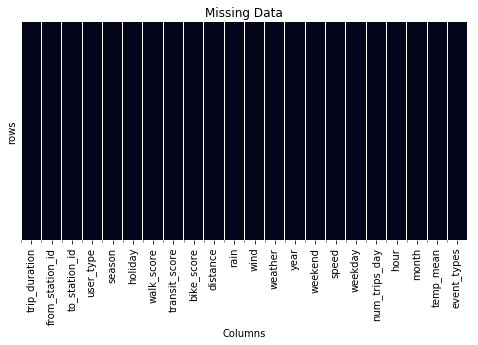

In [13]:
# Percent of total NaN values
print('Percent of missing data: {}'.format(df.isnull().sum().sum()/df.count().sum()))
print('Number of rows and columns: {}'.format(df.shape))

# Plot Visual of Nan Values
fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(df.isnull(), cbar=False)
ax.set_title('Missing Data')
ax.set_xticks(np.arange(len(df.columns)),['trip_duration', 'from_station_id', 'to_station_id', 'user_type','season', 'holiday', 'walk_score', 'transit_score', 'bike_score','distance', 'rain', 'wind', 'weather', 'year', 'weekend', 'speed','weekday', 'num_trips_day', 'hour', 'month', 'temp_mean','event_types'])
ax.set_xlabel('Columns')
ax.set_yticks([])
ax.set_ylabel('rows')
plt.show()

__Lasso:__

Lasso  performs regularization by adding to the loss function a penalty term of the absolute value of each coefficient multiplied by some alpha. This is also known as L1 regularization because the regularization term is the L1 norm of the coefficients.

[ 1.08581181e-02 -0.00000000e+00 -0.00000000e+00 -1.47893098e-02
  0.00000000e+00 -0.00000000e+00  9.78378888e-03  0.00000000e+00
 -2.62722224e-01  4.47725220e-02 -2.38528161e-17  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -2.63788002e-01 -9.27944603e-03  7.19387884e-02
 -1.23887255e-01 -0.00000000e+00  1.11871496e-01  0.00000000e+00
 -0.00000000e+00 -7.81916500e-02 -1.99547455e-03  2.38528161e-17
 -0.00000000e+00 -6.91813608e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  5.63921261e-02  0.00000000e+00
  0.00000000e+00 -7.39978501e-03  1.33293346e+00 -0.00000000e+00]


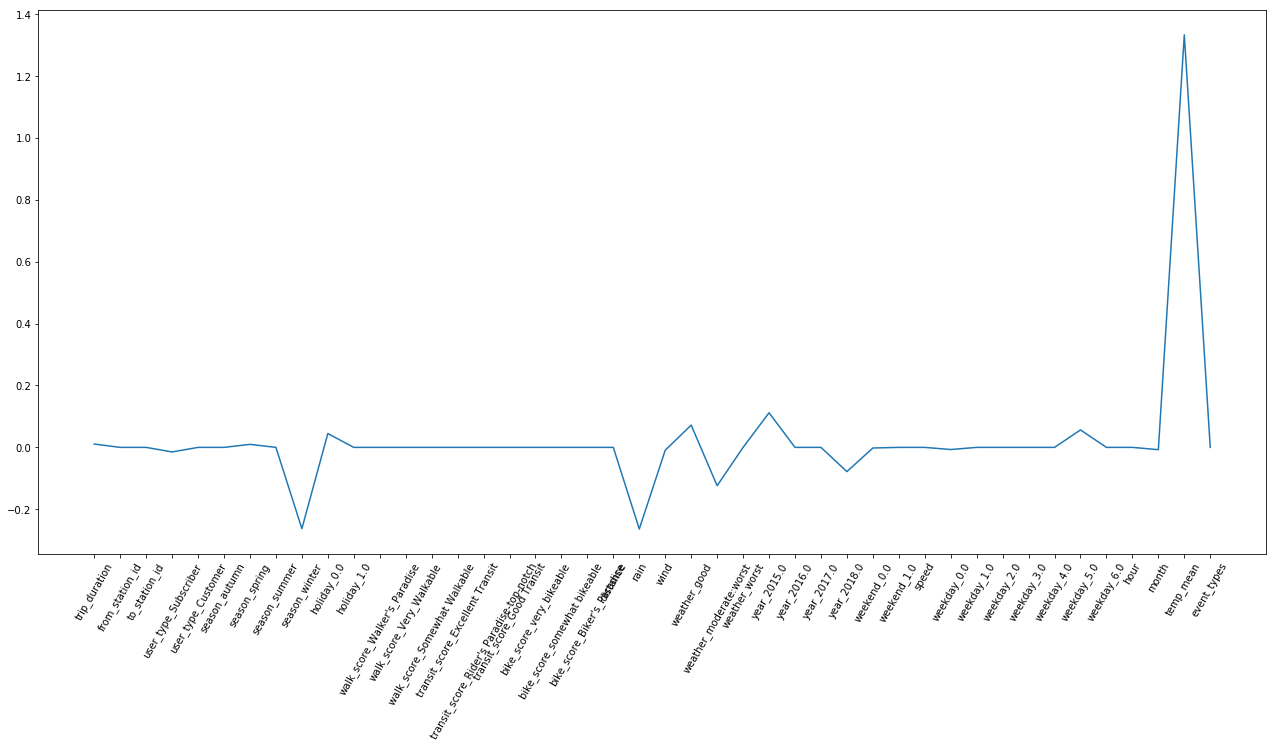

In [16]:
# Import Lasso
from sklearn.linear_model import Lasso

df_columns = pd.DataFrame(X_train)
df_columns.shape

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha = .0001,normalize = True)

# Fit the regressor to the data
lasso.fit(X_train,y_train)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)
fig = plt.figure(figsize=(22,10))
# Plot the coefficients
plt.plot(range(len(df_columns.columns)), lasso.coef_);
plt.xticks(range(len(df_columns.columns)), df_columns.columns.values, rotation=60)

plt.show()


In [17]:
validate_result(lasso, 'Lasso Regression')

Lasso Regression :
R2 score:  0.6788815127373728
RMSE:  0.31619049303002844


In [18]:
Tuned_models = {}
Tuned_models['Lasso_all'] = lasso
Tuned_models

{'Lasso_all': Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=True, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

__Ridge Regularization__

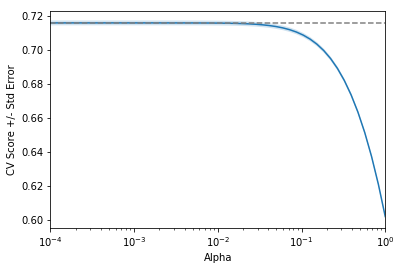

In [14]:
'''Regularization II: Ridge
 If we take the sum of the squared values of the coefficients multiplied by some alpha - like in Ridge regression 
- we would be computing the L2 norm. Here, we will fit ridge regression models over a range of different alphas, and plot cross-validated R2 
scores for each, using this function below  which plots the R2 score as well as standard error for each alpha:'''

# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()
    
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize = True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train, y_train,  cv=10)
    
    # Append the mean of r to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)


The elbow starts bending at 1/100 alpha which happens to be the optimal alpha

In [19]:
# Create a ridge regressor: ridge
ridge = Ridge(alpha = 0.01,normalize = True)


ridge_all = ridge.fit(X_train,y_train)
validate_result(ridge_all,"Ridge")
Tuned_models['Ridge_all'] = ridge_all

Ridge :
R2 score:  0.7214711516809557
RMSE:  0.29447690831174056


__Decision Tree:__

In [16]:
# Import necessary modules
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

dt = DecisionTreeRegressor(max_depth=4,
                           
                            min_samples_split=5,
                            max_leaf_nodes=10)
dt.fit(X_train,y_train)
validate_result(dt, 'Decision Tree Standard')


Decision Tree Standard :
R2 score:  0.6971487872977161
RMSE:  0.30706534949950876


In [17]:
param_grid = {
              "min_samples_split": [10, 50, 100],
              
              "min_samples_leaf": [20, 40, 60],
              "max_leaf_nodes": [5, 20, 100]
              }
grid_cv_dt = GridSearchCV(dt, param_grid, cv=5)
grid_cv_dt.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [10, 50, 100], 'min_samples_leaf': [20, 40, 60], 'max_leaf_nodes': [5, 20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
dt_model = grid_cv_dt.best_estimator_
print("R-Squared with cv:{}".format(grid_cv_dt.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dt.best_params_))
print("Best estimator:")
print(dt_model)

R-Squared with cv:0.7612249697299441
Best Hyperparameters::
{'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}
Best estimator:
DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=100, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


In [19]:
#with best hyperparameters
dt1 = DecisionTreeRegressor(max_depth=4,
                           min_samples_leaf= 20,
                           min_samples_split=10,
                           max_leaf_nodes=100)
dt1.fit(X_train,y_train)
validate_result(dt1, 'Decision Tree with best hyperparameters')
print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(dt1,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))



Decision Tree with best hyperparameters :
R2 score:  0.7636108507206842
RMSE:  0.27128758655964413

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.75862331 0.76402583 0.76391154 0.76126584 0.75829833]
Average 5-Fold CV Score: 0.7612249679095018


In [20]:
Tuned_models['DT_all'] = dt1

__Linear Regression using all the features:__

Now, let's perform a 5-fold cross validation on the data. By default, scikit-learn's cross_val_score() function uses R2 as the metric of choice for regression. Since we are performing 5-fold cross-validation, the function will return 5 scores. We will compute these 5 scores and then take their average.



In [21]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
steps = [
         ('scaler', StandardScaler()),
         ('reg_all',  LinearRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)


# Fit the regressor to the training data
reg_all = pipeline.fit(X_train,y_train)

## Predict on the test data: y_pred scaled
y_pred = reg_all.predict(X_test)


# Compute and print R^2 and RMSE
validate_result(reg_all, 'Linear regression')

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg_all,X_train,y_train,cv = 5)
# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))




Linear regression :
R2 score:  0.7215492957540717
RMSE:  0.29443559618293375

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.71484261 0.71812039 0.71755467 0.71746402 0.71216856]
Average 5-Fold CV Score: 0.7160300492878349


In [22]:
Tuned_models['LinearReg_all'] = reg_all

__Random Forest Regression:__

In [23]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

We will now evaluate the test set RMSE of the random forests regressor rf that was trained

In [24]:
# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
# Compute and print R^2 and RMSE
#print("R^2: {}".format(rmse_test.score(X_test, y_test)))
# Print rmse_test
#print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
#Compute and print 
validate_result(rf, 'Random forest Regressor ')


Random forest Regressor  :
R2 score:  0.9992925216659934
RMSE:  0.014841326703839646


In [27]:
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [28]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest:n_estimators
# Number of features to consider at every split :max_features = ['auto', 'sqrt']
# Maximum number of levels in tree:max_depth
# Minimum number of samples required to split a node:min_samples_split 
# Minimum number of samples required at each leaf node:min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree:bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': [200, 400, 600, 800, 1000],
               'max_features': ['auto', 'sqrt'],
            
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf':  [1, 2, 4],
               }
pprint(random_grid)


{'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,  cv = 5, verbose=2, random_state=42, n_jobs = -1)


In [18]:
# Fit the random search model
rf_random.fit(X_train,y_train)

rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 112.1min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

Copying the results:
Fitting 5 folds for each of 10 candidates, totalling 50 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 52.9min

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 112.1min finished

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}
​

In [21]:
rf_random.best_score_


0.9998203540208344

In [25]:

# Use the best parameters found from above to build the model

rf_regressor = RandomForestRegressor(n_estimators = 200,min_samples_split= 2,min_samples_leaf= 1, max_features = 'auto') 
rf_regressor.fit(X_train,y_train)

# Predicting the values 

y_pred = rf_regressor.predict(X_test) 

In [26]:
Tuned_models['RandomForest_all'] = rf_regressor

In [27]:

# Compute MSE
mse_test = MSE(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
# Compute and print R^2 and RMSE
print("R^2: {}".format(rf_regressor.score(X_test, y_test)))

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('Test set RMSE of regressor: {:.3f}'.format(rmse_test))

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(rf_regressor,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

R^2: 0.9992796544759983
Test set RMSE of regressor: 0.015

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.99962518 0.99980459 0.99982338 0.9997099  0.99996473]
Average 5-Fold CV Score: 0.9997855564662379


__Visualizing features importances__

Now we will determine which features were the most predictive according to the random forests regressor rf that we trained.

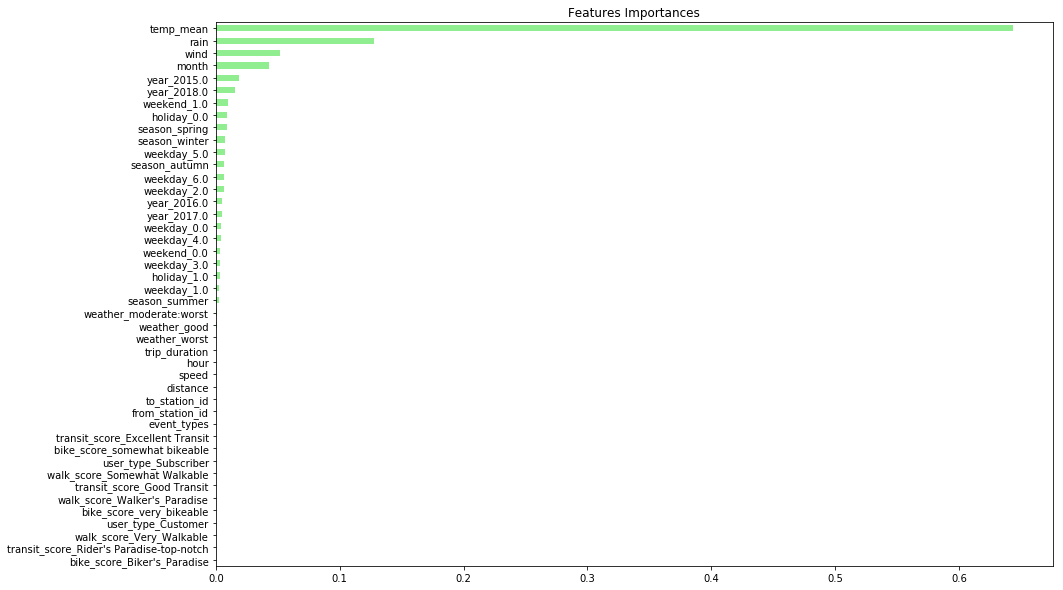

In [28]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf_regressor.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()
fig = plt.figure(figsize=(15,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

__Xgboost Regression:__

D:\sk\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost Regression:
R2 score standard:  0.4789367517056061
RMSE:  0.4027739502283253
R2 score of tuned model:  0.684513804258256
RMSE:  0.3134052979741757


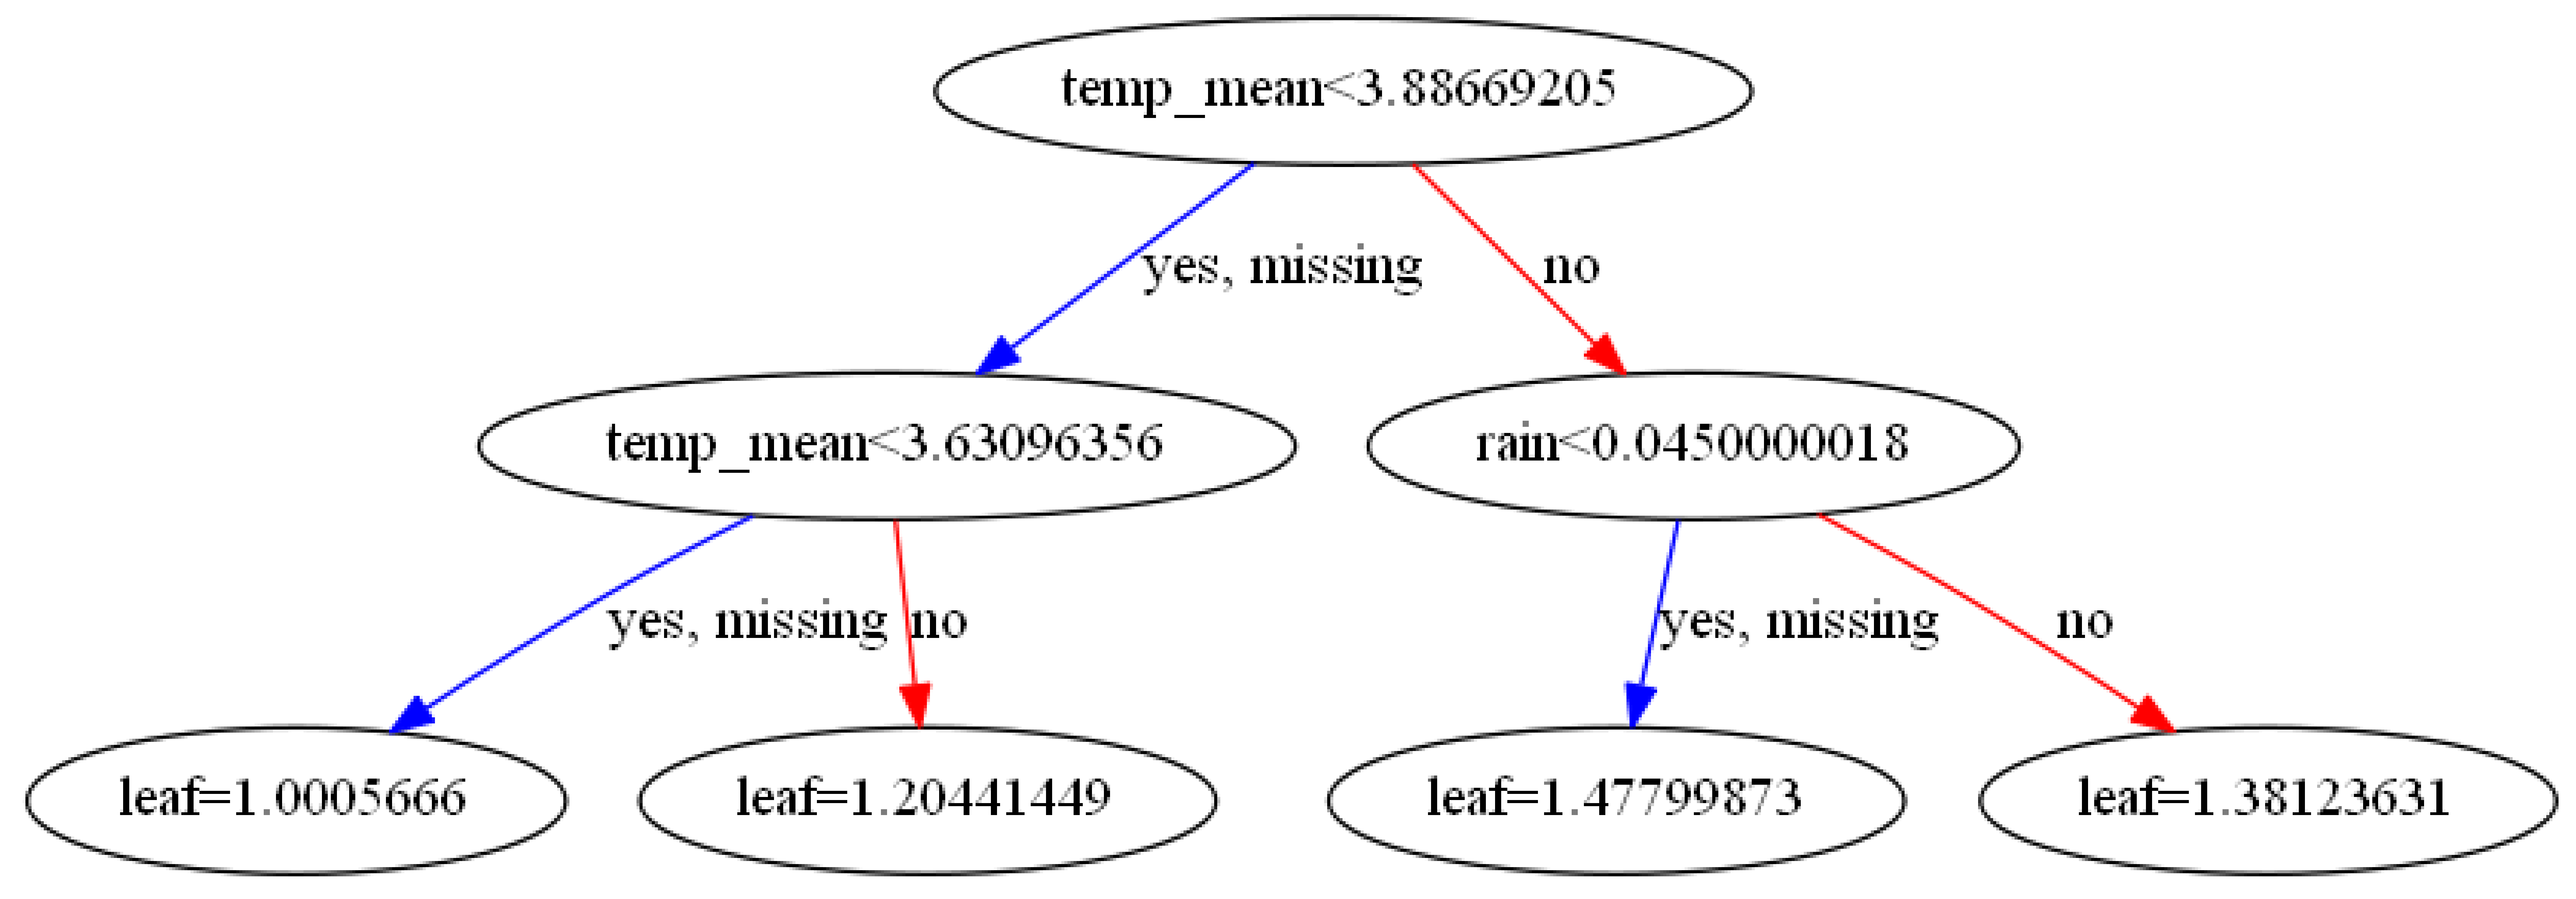

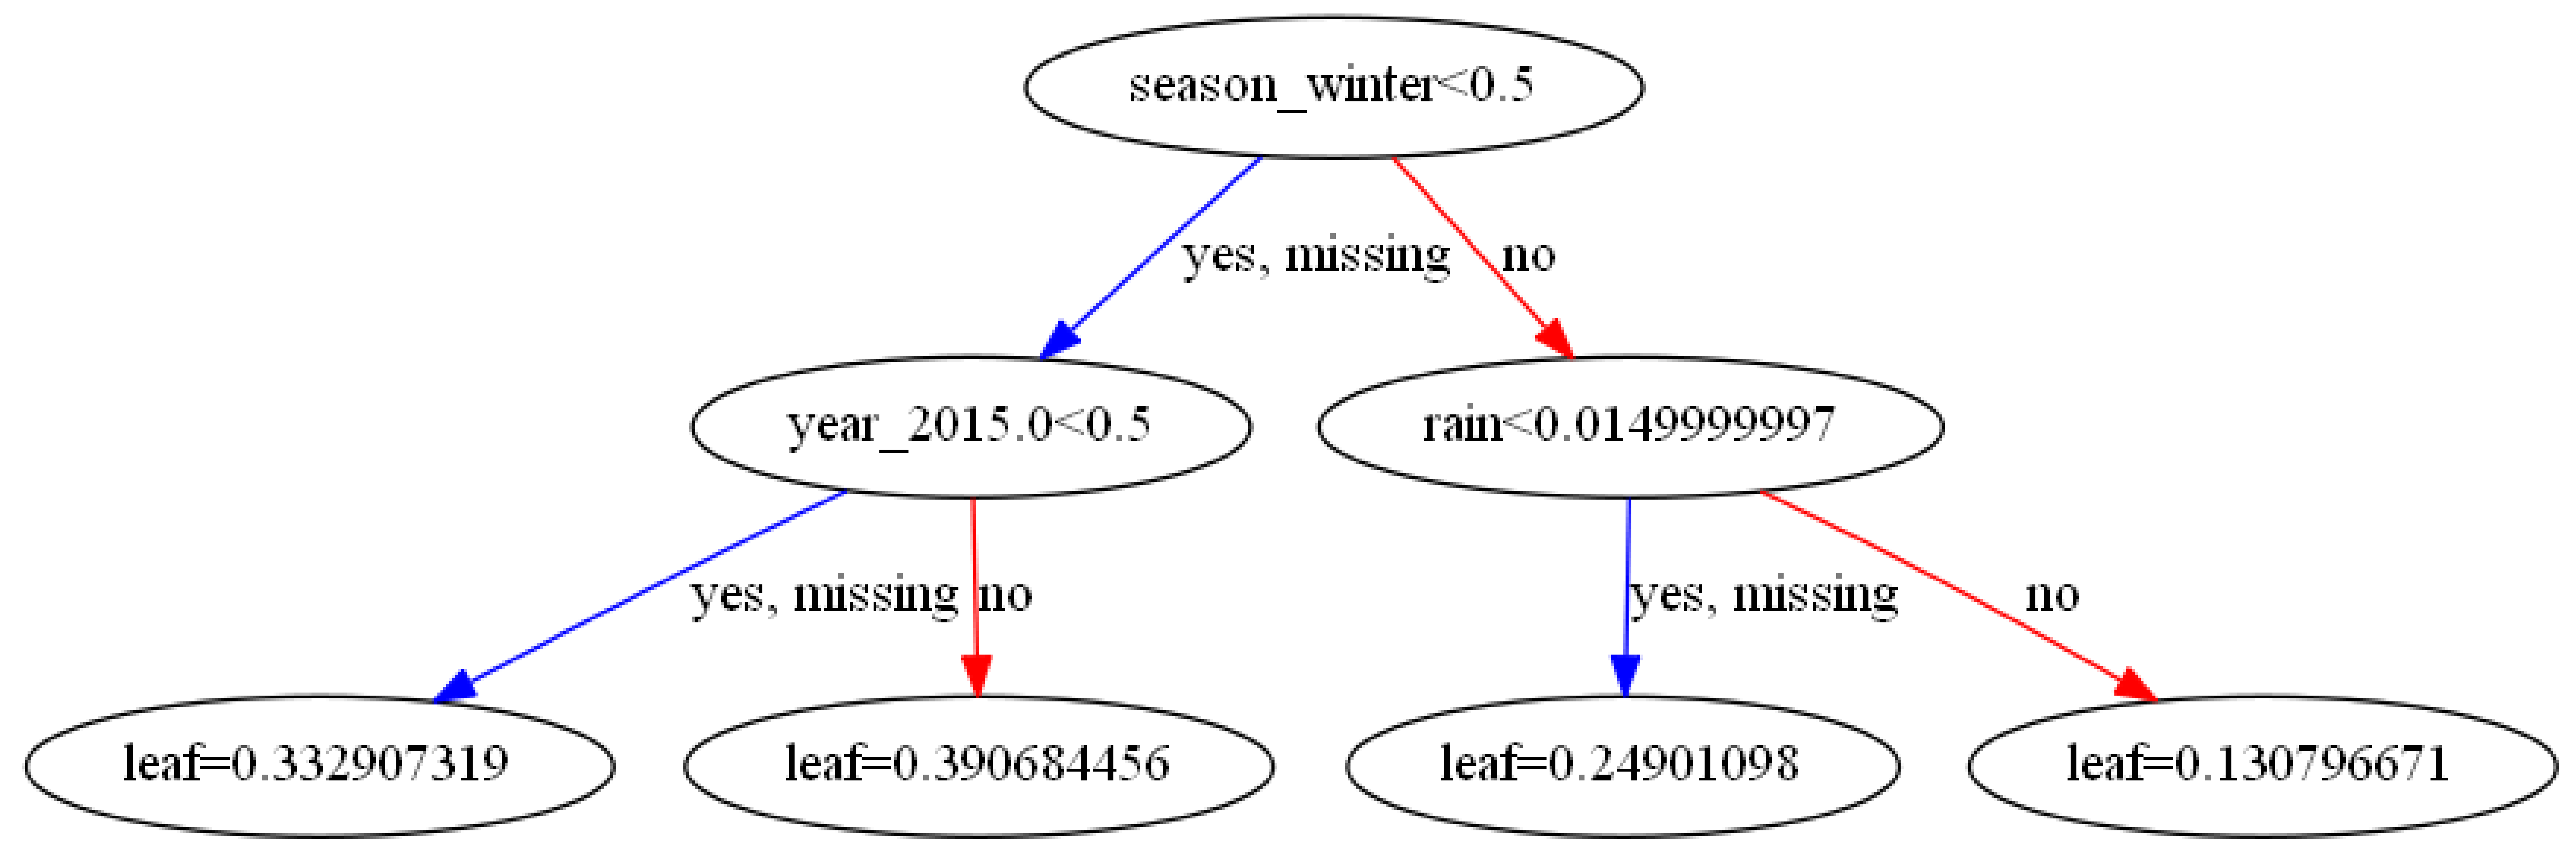

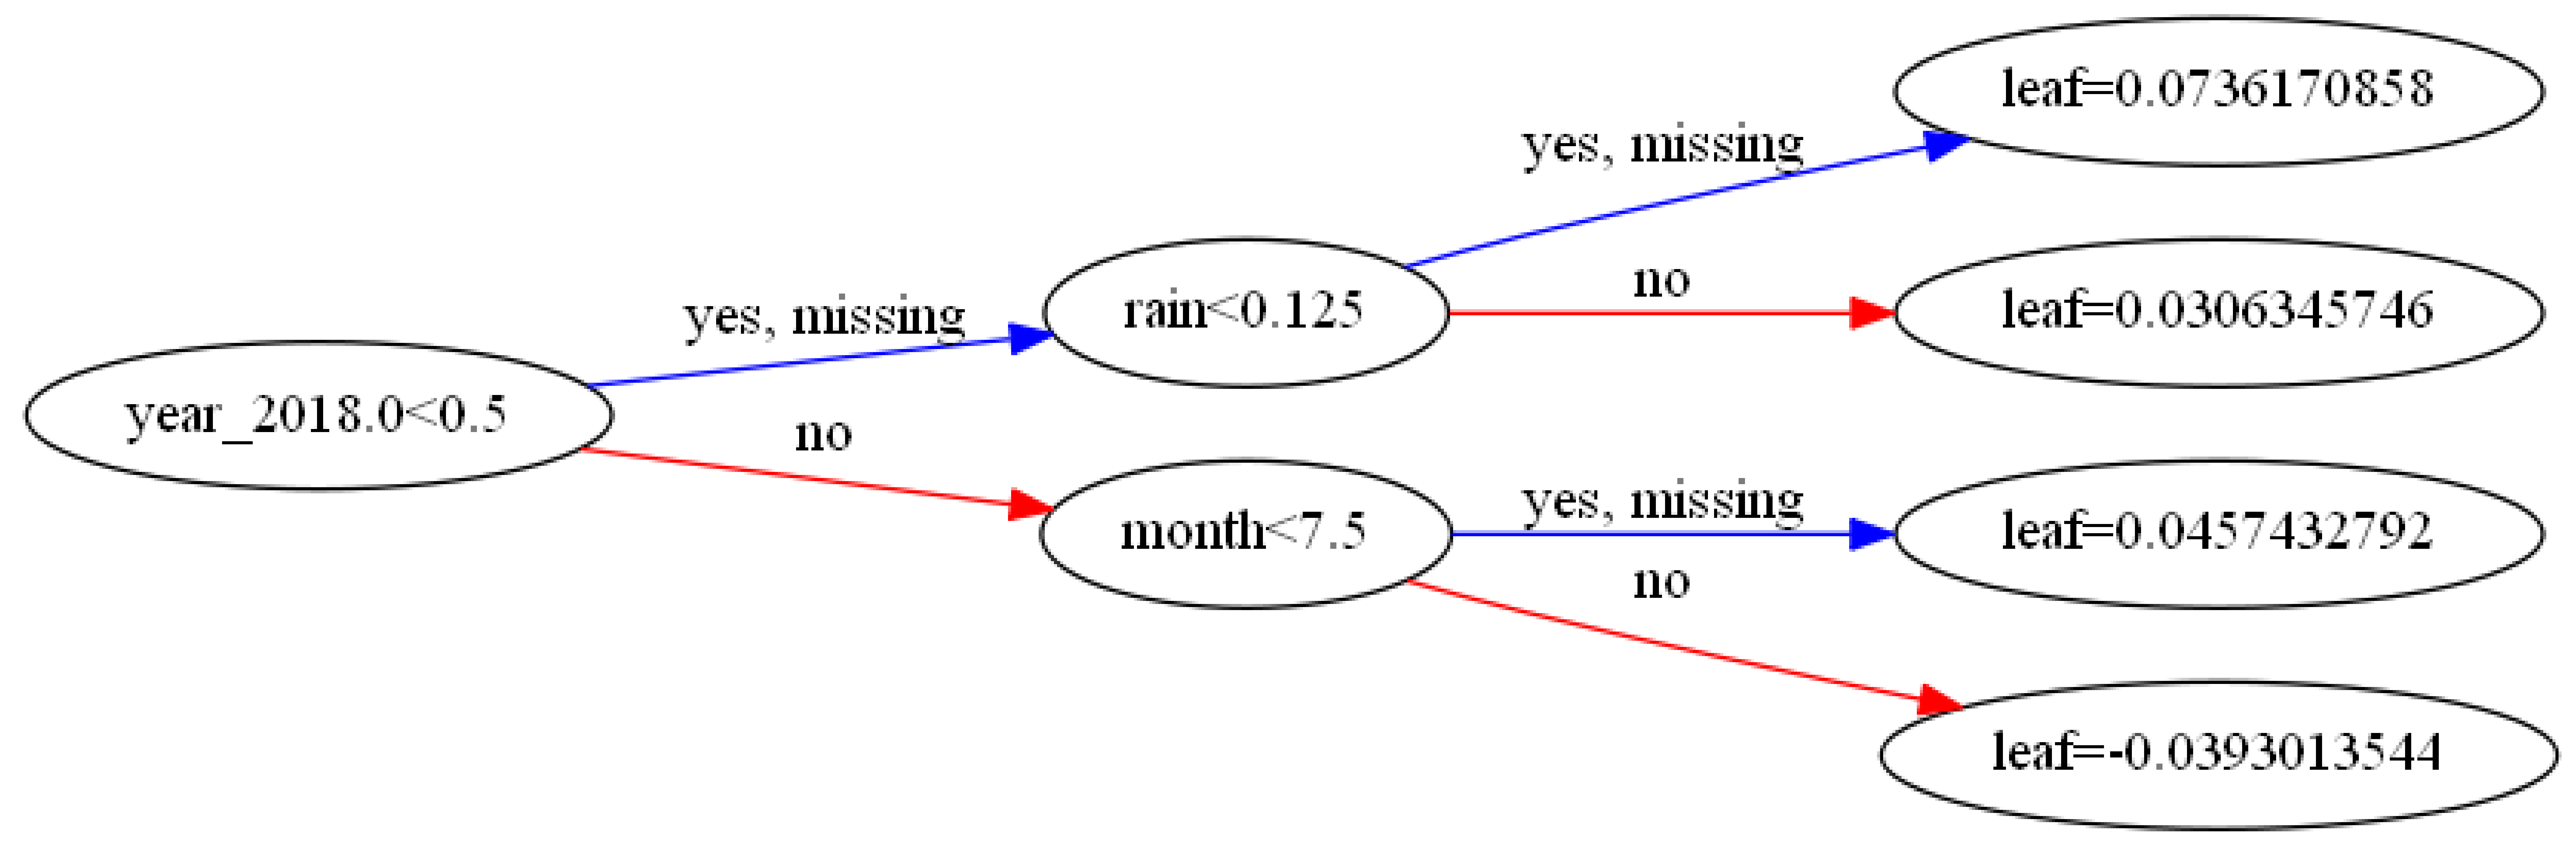

In [29]:

import xgboost as xgb


DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

params = {"booster":"gblinear","objective":"reg:squarederror"}

xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)

preds = xg_reg.predict(DM_test)
R2_score = r2_score(y_test, preds)
RSME_score = np.sqrt(mean_squared_error(y_test, preds))
print("Xgboost Regression:")
print('R2 score standard: ', R2_score)
print('RMSE: ', RSME_score)

"""Visualizing individual XGBoost trees
 Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire dataset."""



# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=DM_train, num_boost_round=10)
preds = xg_reg.predict(DM_test)
R2_score = r2_score(y_test, preds)
RSME_score = np.sqrt(mean_squared_error(y_test, preds))
print('R2 score of tuned model: ', R2_score)
print('RMSE: ', RSME_score)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
plt.show()
# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9,rankdir="LR")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
plt.show()

Tuned_models['Xgboost_all'] = xg_reg

__GB regressor__

In [30]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                               n_estimators=200,
                               random_state=2)
# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)


# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**(1/2)
print("R^2: {}".format(gb.score(X_test, y_test)))


# Print RMSE
print('RMSE : {:.3f}'.format(rmse_test))


R^2: 0.926198878049824
RMSE : 0.152


In [130]:
#Set the hyperparameter grid of RF
# Define the dictionary 'params_rf'
params_rf = {
             'n_estimators': [100, 350, 500],
             'max_features': ['log2', 'auto', 'sqrt'],
             'min_samples_leaf': [2, 10, 30], 
             }
# Import GridSearchCV
from sklearn.model_selection import  GridSearchCV

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       refit = True,
                       verbose=1,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)
# Extract the best estimator

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**(1/2)

print("Best Hyperparameters::\n{}".format(grid_rf.best_params_))
best_model = grid_rf.best_estimator_
# Predict test set labels
y_pred = best_model.predict(X_test)

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 88.4min finished


Best Hyperparameters::
{'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 500}
Test RMSE of best model: 0.136


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 88.4min finished
Best Hyperparameters::
{'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 500}
Test RMSE of best model: 0.136
1
​


In [31]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb_all = GradientBoostingRegressor(max_features= 'auto',
                               n_estimators=500,
                               min_samples_leaf = 2,
                               random_state=2)
# Fit gb to the training set
gb_all.fit(X_train, y_train)

# Predict test set labels
y_pred = gb_all.predict(X_test)


# Compute MSE
mse_test = MSE(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
# Compute and print R^2 and RMSE
print("R^2: {}".format(gb_all.score(X_test, y_test)))

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('RMSE: {:.3f}'.format(rmse_test))

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(gb_all,X_test,y_test,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Tuned_models['GadientBoosting_all'] = gb_all

R^2: 0.9272772003428783
RMSE: 0.150

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.91969421 0.92373103 0.92163328 0.92825206 0.92624827]
Average 5-Fold CV Score: 0.9239117700363295


__Support Vector Regressor with cross-validation__

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR
# SVR with  linear Kernel
from sklearn.preprocessing import MinMaxScaler
# Setup the pipeline steps: steps
steps = [('scaler', MinMaxScaler(feature_range = (-1,1))),
        ('svr_lin',  SVR(kernel='linear'))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)


# Fit the regressor to the training data
svr_all = pipeline.fit(X_train,y_train)



#Compute and print 
validate_result(svr_all, 'Support Vector Regressor ')


Support Vector Regressor  :
R2 score:  0.7105537409526643
RMSE:  0.30019269764623746


Compute 5-fold cross-validation scores on all the features

R^2 scores: [0.7106868  0.7037071  0.71636176 0.71339459 0.70819176]

Average 5-Fold CV Score: 0.710468400129525


__Feature Selection:__

Now, we will select supporting features using sklearn's SelectFromModel library using Lasso regressor 

In [72]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(lasso)
sfm.fit(X_train, y_train.ravel())
display(X_train.head(1))
sup = sfm.get_support()
zipped = zip(X_train,sup)
print(*zipped)

,trip_duration,from_station_id,to_station_id,user_type_Subscriber,user_type_Customer,season_autumn,season_spring,season_summer,season_winter,holiday_0.0,...,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour,month,temp_mean,event_types
tripdate,,,,,,,,,,,,,,,,,,,,,
2017-04-23,6.077642,23.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,17.0,3.0,3.960813,0.0


('trip_duration', True) ('from_station_id', False) ('to_station_id', False) ('user_type_Subscriber', True) ('user_type_Customer', False) ('season_autumn', False) ('season_spring', True) ('season_summer', False) ('season_winter', True) ('holiday_0.0', True) ('holiday_1.0', False) ("walk_score_Walker's_Paradise", False) ('walk_score_Very_Walkable', False) ('walk_score_Somewhat Walkable', False) ('transit_score_Excellent Transit', False) ("transit_score_Rider's Paradise-top-notch", False) ('transit_score_Good Transit', False) ('bike_score_very_bikeable', False) ('bike_score_somewhat bikeable', False) ("bike_score_Biker's_Paradise", False) ('distance', False) ('rain', True) ('wind', True) ('weather_good', True) ('weather_moderate:worst', True) ('weather_worst', False) ('year_2015.0', True) ('year_2016.0', False) ('year_2017.0', False) ('year_2018.0', True) ('weekend_0.0', True) ('weekend_1.0', False) ('speed', False) ('weekday_0.0', True) ('weekday_1.0', False) ('weekday_2.0', False) ('wee

We will be dropping few columns based on feature selection results and transforming them the same way as we did before

In [20]:
df3 = df.drop(['from_station_id', 'to_station_id','holiday', 'walk_score', 'transit_score', 'bike_score','event_types','speed','distance','hour'], axis = 1)
import category_encoders as ce
from category_encoders import *
le = LabelEncoder()
numeric_cols = ['trip_duration', 'rain', 'wind', 'speed','temp_mean']
label_cat_features = ['month']
ohe_cat_features =  ['season','year','weather','user_type','weekend','weekday']
#ord_features = ['start_time', 'stop_time']

X , y = df3.drop('num_trips_day', 1).values, df3.num_trips_day.values
#df.drop(['start_time','stop_time'], axis = 1, inplace = True)
X_train_df, X_test_df, y_train, y_test = train_test_split(df3.drop('num_trips_day', 1), df3.num_trips_day, 
                                                    test_size=0.33, random_state=42)


def encoding(X_train_df, X_test_df, numeric_cols,label_cat_features,ohe_cat_features):
   
    for x in label_cat_features:
        names = le.fit_transform(X_train_df[x])
        names_mappings = {index: label for index, label in enumerate(le.classes_)}
        X_train_df[x] = names
        names2 = le.transform(X_test_df[x])
        names_mappings = {index: label for index, label in enumerate(le.classes_)}
        X_test_df[x] = names2
        
    # use one hot encoding to encode categorical features
    ohe = OneHotEncoder(cols=ohe_cat_features, use_cat_names=True).fit(X_train_df)
    # transform the datasets
    X_train_df = ohe.transform(X_train_df)
    X_test_df = ohe.transform(X_test_df)
    
    return X_train_df, X_test_df, 
df4 = encoding(X_train_df, X_test_df, numeric_cols,label_cat_features,ohe_cat_features)
X_train, X_test = df4[0].astype(float),df4[1].astype(float)

**Feature Selected Tuned Models:**

In [21]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('reg_all',  LinearRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)


# Fit the regressor to the training data
reg_all = pipeline.fit(X_train,y_train)

## Predict on the test data: y_pred scaled
y_pred = reg_all.predict(X_test)

validate_result(reg_all, 'Linear Regression on selected features')

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg_all,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))


Linear Regression on selected features :
R2 score:  0.7201161343021774
RMSE:  0.2951923408551587

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.71361498 0.71628192 0.71571321 0.71551465 0.71025329]
Average 5-Fold CV Score: 0.7142756092275091


In [22]:
Feature_selected_model = {}
Feature_selected_model["Linear Regression_selected"] = reg_all
Feature_selected_model

{'Linear Regression_selected': Pipeline(memory=None,
      steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg_all', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False))])}

In [35]:
# Import necessary modules
from sklearn.tree import DecisionTreeRegressor
#with best hyperparameters
dt1 = DecisionTreeRegressor(max_depth=4,
                           min_samples_leaf= 20,
                           min_samples_split=10,
                           max_leaf_nodes=100)
dt1.fit(X_train,y_train)
validate_result(dt1, 'Decision Tree on selected features with best hyperparameters')

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(dt1,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
Feature_selected_model["Decision_tree_selected"] = dt1

Decision Tree on selected features with best hyperparameters :
R2 score:  0.7636108507206838
RMSE:  0.27128758655964436

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.75862331 0.76402583 0.76391154 0.76126584 0.75829833]
Average 5-Fold CV Score: 0.761224967909503


D:\sk\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


R2 score:  0.684513804258256
RMSE:  0.3134052979741757


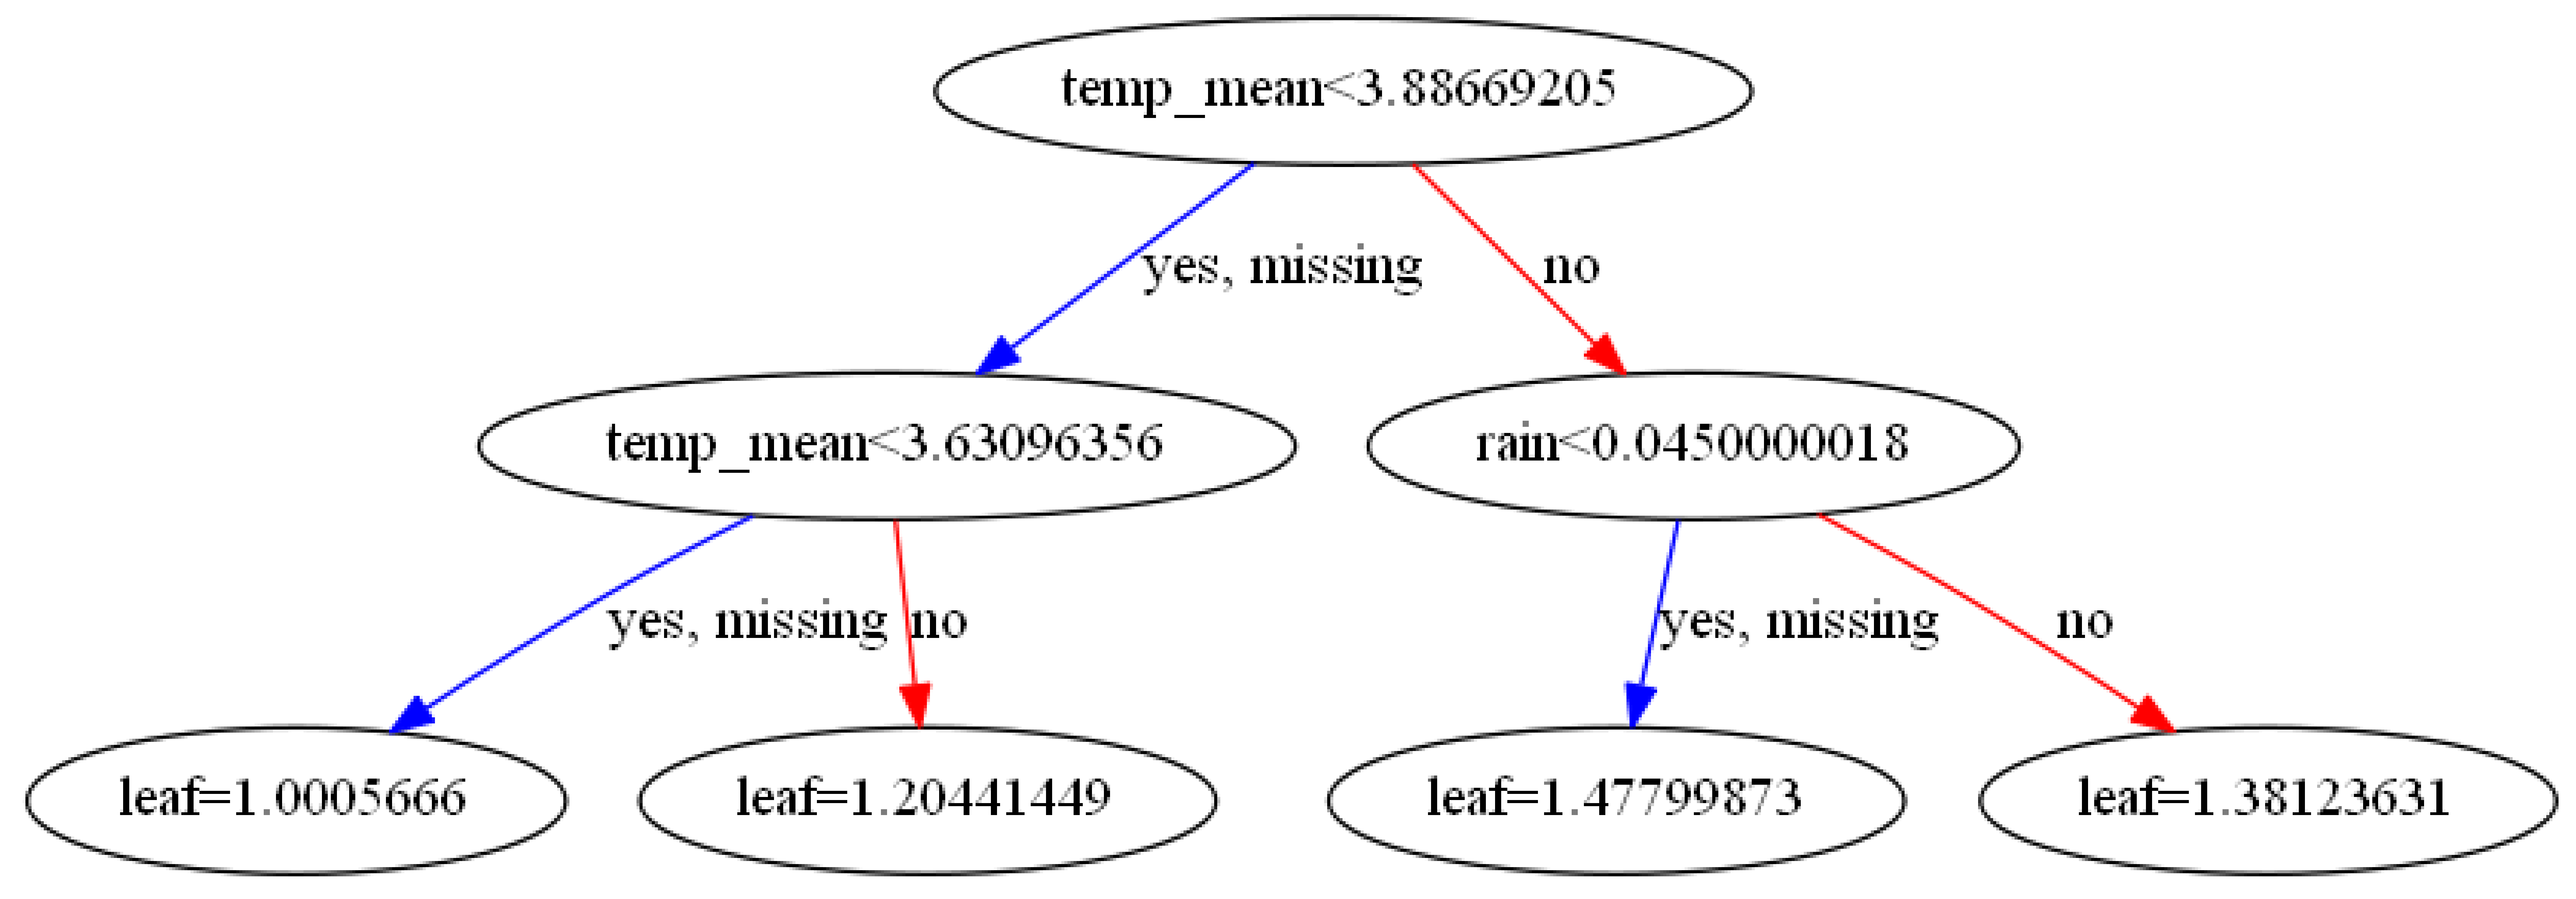

In [36]:

#Linear base learners example: learning API only
import xgboost as xgb


DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=DM_train, num_boost_round=10)
preds = xg_reg.predict(DM_test)
R2_score = r2_score(y_test, preds)
RSME_score = np.sqrt(mean_squared_error(y_test, preds))
"""Visualizing individual XGBoost trees
 Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire dataset."""

print('R2 score: ', R2_score)
print('RMSE: ', RSME_score)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
Feature_selected_model["XgBoost_selected"] = xg_reg

In [37]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_features= 'auto',
                               n_estimators=500,
                               min_samples_leaf = 2,
                               random_state=2)
# Fit gb to the training set
gb.fit(X_train, y_train)
Feature_selected_model["Gradient_Boosting_selected"] = gb
# Predict test set labels
y_pred = gb.predict(X_test)


# Compute MSE
mse_test = MSE(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('GradientBoostingRegressor')
# Compute and print R^2 and RMSE
print("R^2: {}".format(gb.score(X_test, y_test)))

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('RMSE: {:.3f}'.format(rmse_test))

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(gb,X_test,y_test,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

GradientBoostingRegressor
R^2: 0.9296409136800446
RMSE: 0.148

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.92450865 0.92735959 0.92423673 0.92998164 0.92693682]
Average 5-Fold CV Score: 0.9266046838230855


Lasso Regression :
R2 score:  0.6788818008849888
RMSE:  0.3161903511671946


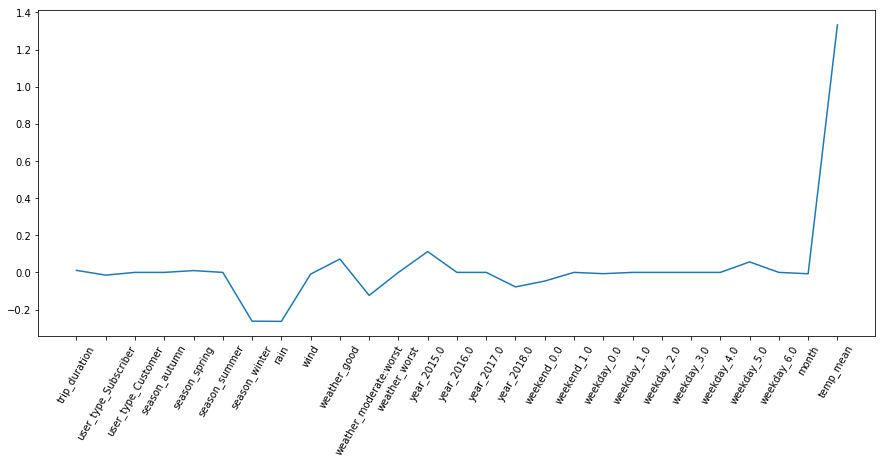

In [38]:
# Import Lasso
from sklearn.linear_model import Lasso

df_columns = pd.DataFrame(X_train)
df_columns.shape

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha = .0001,normalize = True)

# Fit the regressor to the data
lasso.fit(X_train,y_train)
Feature_selected_model["Lasso_selected"] = lasso
# Compute and print the coefficients
lasso_coef = lasso.coef_
validate_result(lasso, 'Lasso Regression')
fig = plt.figure(figsize=(15,6))
# Plot the coefficients
plt.plot(range(len(df_columns.columns)), lasso.coef_);
plt.xticks(range(len(df_columns.columns)), df_columns.columns.values, rotation=60)

plt.show()


In [39]:

# Use the best parameters found from above to build the model

rf_regressor = RandomForestRegressor(n_estimators = 200,min_samples_split= 2,min_samples_leaf= 1, max_features = 'auto') 
rf_regressor.fit(X_train,y_train)
Feature_selected_model["RF_Regression_selected"] = rf_regressor
# Predicting the values 

y_pred = rf_regressor.predict(X_test) 

In [40]:

# Compute MSE
mse_test = MSE(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
# Compute and print R^2 and RMSE
print("R^2: {}".format(rf_regressor.score(X_test, y_test)))

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('Test set RMSE of regressor: {:.3f}'.format(rmse_test))

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(rf_regressor,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

R^2: 0.9993003408407285
Test set RMSE of regressor: 0.015

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.99974979 0.999855   0.99991405 0.99984895 0.99997597]
Average 5-Fold CV Score: 0.9998687530883433


In [23]:

# Create a ridge regressor: ridge
ridge = Ridge(alpha = 0.01,normalize = True)


ridge = ridge.fit(X_train,y_train)
validate_result(ridge,"Ridge")
Feature_selected_model['Ridge_selected'] = ridge

Ridge :
R2 score:  0.7199296866053274
RMSE:  0.2952906472883729


In [138]:
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_colwidth', 200)
pd.DataFrame(list(Tuned_models.items()))

,0,1
0,Lasso_all,"Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=True, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)"
1,Ridge_all,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=True, random_state=None, solver='auto', tol=0.001)"
2,DT_all,"DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,\n max_leaf_nodes=100, min_impurity_decrease=0.0,\n min_impurity_split=None, min_samples_leaf=20,\n ..."
3,LinearReg_all,"Pipeline(memory=None,\n steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg_all', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,\n normal..."
4,RandomForest_all,"(DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',\n max_leaf_nodes=None, min_impurity_decrease=0.0,\n min_impurity_split=None, min_samples_leaf=1,\n ..."
5,Xgboost_all,<xgboost.core.Booster object at 0x000001B3E86A3F60>
6,GadientBoosting_all,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min..."


In [60]:
#df7 = pd.DataFrame(list(Feature_selected_model.items()))

In [61]:
score_results = pd.read_csv('D:/sr/mresults.csv')
score_results

,model name,R^2 (tuned),RMSE (tuned),Average 5-fold cross-validation R^2
0,Lasso,0.678882,0.316190,NaN
1,Ridge,0.721471,0.294477,NaN
2,Decision Tree,0.763611,0.271288,0.761225
3,LinearRegression,0.721549,0.294436,0.716030
4,RandomForest,0.999280,0.015000,0.999786
5,Xgboost,0.684514,0.313405,NaN
6,GadientBoosting,0.927277,0.150000,0.923912
7,Lasso_selected_features,0.678882,0.316190,NaN
8,Ridge_selected_features,0.719930,0.295291,NaN
9,Decision_tree_selected_features,0.763611,0.271288,0.761225


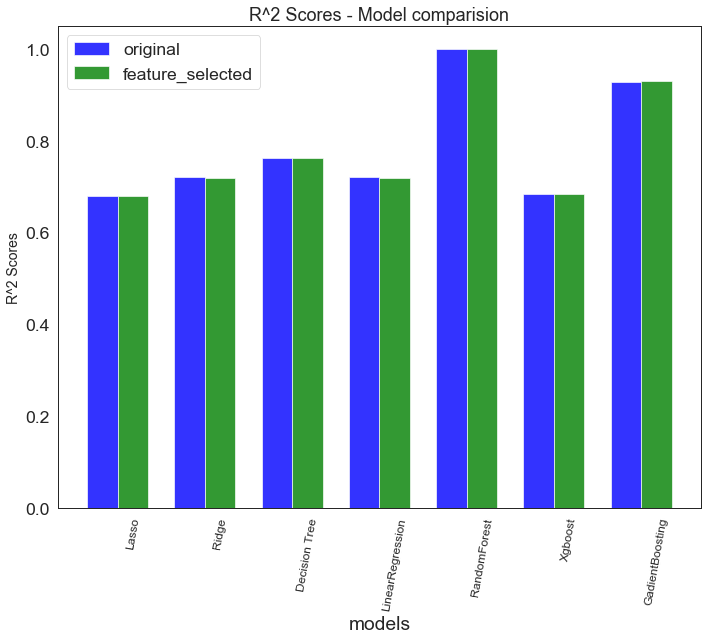

In [63]:
import matplotlib.pyplot as plt
# data to plot
n_groups = 7
original = score_results['R^2 (tuned)'][0:7]
fs = score_results['R^2 (tuned)'][7:]

# create plot
fig, ax = plt.subplots(figsize = (10,9))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, original, bar_width,alpha=opacity,color='b',label='original')

rects2 = plt.bar(index + bar_width, fs, bar_width,alpha=opacity,color='g',label='feature_selected')

plt.xlabel('models')
plt.ylabel('R^2 Scores',fontsize=14)
plt.title('R^2 Scores - Model comparision',fontsize=18)
plt.xticks(index + bar_width, ('Lasso','Ridge','Decision Tree','LinearRegression','RandomForest','Xgboost','GadientBoosting'),rotation=80,fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

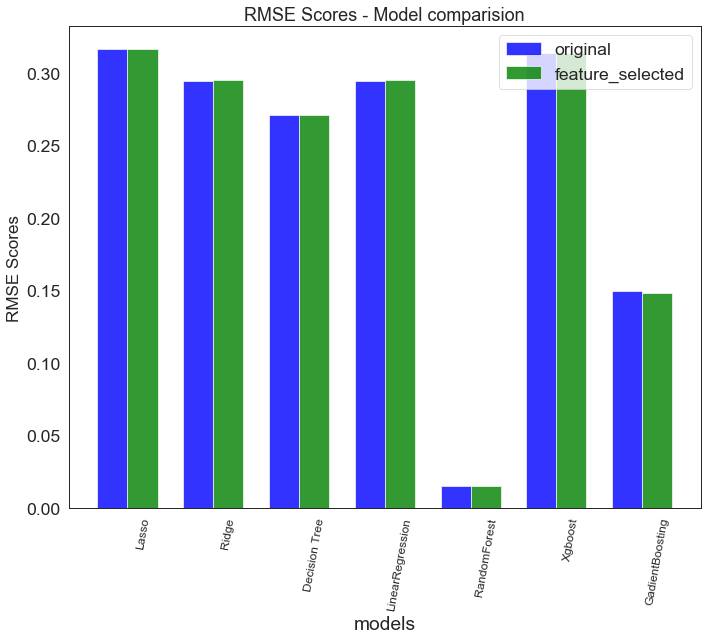

In [64]:
# data to plot
n_groups = 7
original = score_results['RMSE (tuned)'][0:7]
fs = score_results['RMSE (tuned)'][7:]

# create plot
fig, ax = plt.subplots(figsize = (10,9))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, original, bar_width,alpha=opacity,color='b',label='original')

rects2 = plt.bar(index + bar_width, fs, bar_width,alpha=opacity,color='g',label='feature_selected')

plt.xlabel('models')
plt.ylabel('RMSE Scores',fontsize=17)
plt.title('RMSE Scores - Model comparision',fontsize=18)
plt.xticks(index + bar_width, ('Lasso','Ridge','Decision Tree','LinearRegression','RandomForest','Xgboost','GadientBoosting'),rotation=80,fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

As we can see from the plots above, there is no difference in the model performance between original model with all features included and Feature selected model after selecting the best features. Random forest model performs the best since it has R^2 closer to 1 and also has the lowest RMSE. The next best model is Gradient Boosting model

__Model Selection:__

Since Random Forest Regressor performed better than all the other models with regards to R^2 and RMSE, we will use it with all features to train on the training set with best hyper parameters and predict on the test set.
    
Random forest Regressor with all features and best hyperparameters:


In [73]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Use the best parameters found from above to build the model

rf_regressor = RandomForestRegressor(n_estimators = 200,min_samples_split= 2,min_samples_leaf= 1, max_features = 'auto') 
rf_regressor.fit(X_train,y_train)

# Predicting the values 

y_pred = rf_regressor.predict(X_test) 

Now, we have a pre-trained model and can estimate the target variable by making the prediction of the number of trips per day (predictions) and comparing them with the real counts from test data. To make this comparison more illustrative, we will show it both in the forms of table and plot.

In [75]:
# Make prediction by creating results dataframe with both the actual results and predicted results

result = X_test
result['Actual count'] = y_test
result['prediction'] = y_pred.tolist()
result.head(3)

,trip_duration,from_station_id,to_station_id,user_type_Subscriber,user_type_Customer,season_autumn,season_spring,season_summer,season_winter,holiday_0.0,...,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour,month,temp_mean,event_types,Actual count,prediction
tripdate,,,,,,,,,,,,,,,,,,,,,
2016-02-09,5.323010,8.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,8.0,1.0,3.417727,0.0,3.258097,3.258097
2016-07-10,6.624065,4.0,10.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,17.0,6.0,4.276666,0.0,5.710427,5.710427
2016-10-24,6.470800,39.0,41.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,9.0,3.998201,0.0,5.049856,5.049856


By plotting a scatter plot relating to the feature “temp_mean” with predicted values versus the observed values for the dataset, we can get a sense of how accurate the model is.



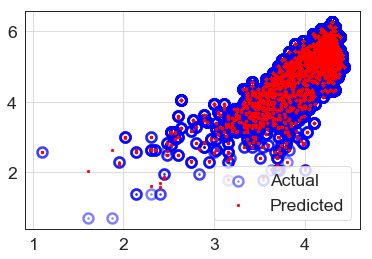

In [76]:
# Define x axis
x_axis = X_test.temp_mean

# Build scatterplot
plt.scatter(x_axis, y_test, c= 'b',alpha = 0.5,lw = 10, marker = '.', label = 'Actual')
plt.scatter(x_axis, y_pred, color= 'r', alpha = 1, marker = '.', label = 'Predicted')

plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

 Root Squared Mean Log Error: 0.005481810873761785


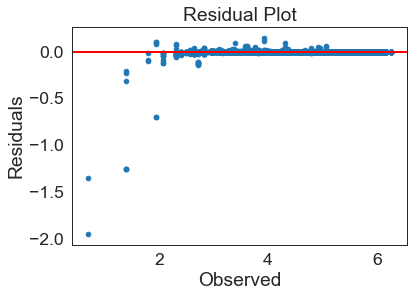

In [77]:
from sklearn.metrics import mean_squared_log_error
# Plot the residuals
residuals = y_test-y_pred
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
## plotting line for zero residual error 
#ax.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2) 
ax.axhline(lw=2,color='red')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text('Residual Plot')
print(' Root Squared Mean Log Error: ' + str(np.sqrt(mean_squared_log_error(y_test, y_pred))))
plt.show()

__Conclusion and Limitations:__

Temperature seems to the most important feature in predicting the number of rentals, followed by rain and wind.
One obvious avenue of research extension would be to attempt demand predictions by adding additional weather variables such as wind chill, humidity, cloud cover, visibility, dew point temperature and air pressure.
Random forest regressor proved to be the best model to predict the daily number of bike share users as it has R^2 closer to 1 and also has the lowest RMSE
For future work, I would like to predict correlations that exist among stations based on their geographical locations and temporal demands.



